In [13]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter
import matplotlib.gridspec as gridspec

from gwbird import detectors
from gwbird import pls
from gwbird.overlap import Response
from gwbird.nell import AngularResponse, Sensitivity_ell
from gwbird import nell

%config InlineBackend.figure_format = 'retina'


plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.family'] = 'serif'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Overlap reduction function

## Ground Based Detectors


Calculate the overlap response between two detectors.

R = Response.overlap(det1, det2, f, psi, pol, shift_angle=False)

Parameters:
- det1, det2: str or list of str
    The name of the detector(s) to consider.
    The names must be in the list of detectors available in the response module.
    The list of available detectors can be obtained by calling the function detectors.available_detectors().
    The names of the detectors are case sensitive.
    If you want to provide a custom detector, you can provide the following information in a list:

    H = [c, xA, xB, l, name]

    - c: array_like of length 3 (Position of the detector in the Earth-centered frame in meters)
    - xA: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - xB: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - l: float (Length of the arm in meters)
    - name: str (Name of the detector)

- f: array_like (Frequency in Hz)
- psi: float (Polarization angle in radians)
- pol: str (Polarization of the signal, 't' for tensor, 'v' for vector, 's' for scalar)

Optional parameters:
- shift_angle: bool or float (Shift the angle of the response if considering ET 2L in radians)



In [24]:

print(detectors.available_detectors())

f = np.logspace(0, 3, 1000)
R_LIGO = Response.overlap('LIGO H', 'LIGO L', f, 0, 't')
R_ET = Response.overlap('ET X', 'ET Y', f, 0, 't')
R_ET2L0 = Response.overlap('ET L1', 'ET L2', f, 0, 't', shift_angle=0)
R_ET2L45 = Response.overlap('ET L1', 'ET L2', f, 0, 't', shift_angle=np.pi/4)


['LIGO H', 'LIGO L', 'Virgo', 'KAGRA', 'CE', 'ET X', 'ET Y', 'ET Z', 'ET L1', 'ET L2', 'LISA X', 'LISA Y', 'LISA Z']


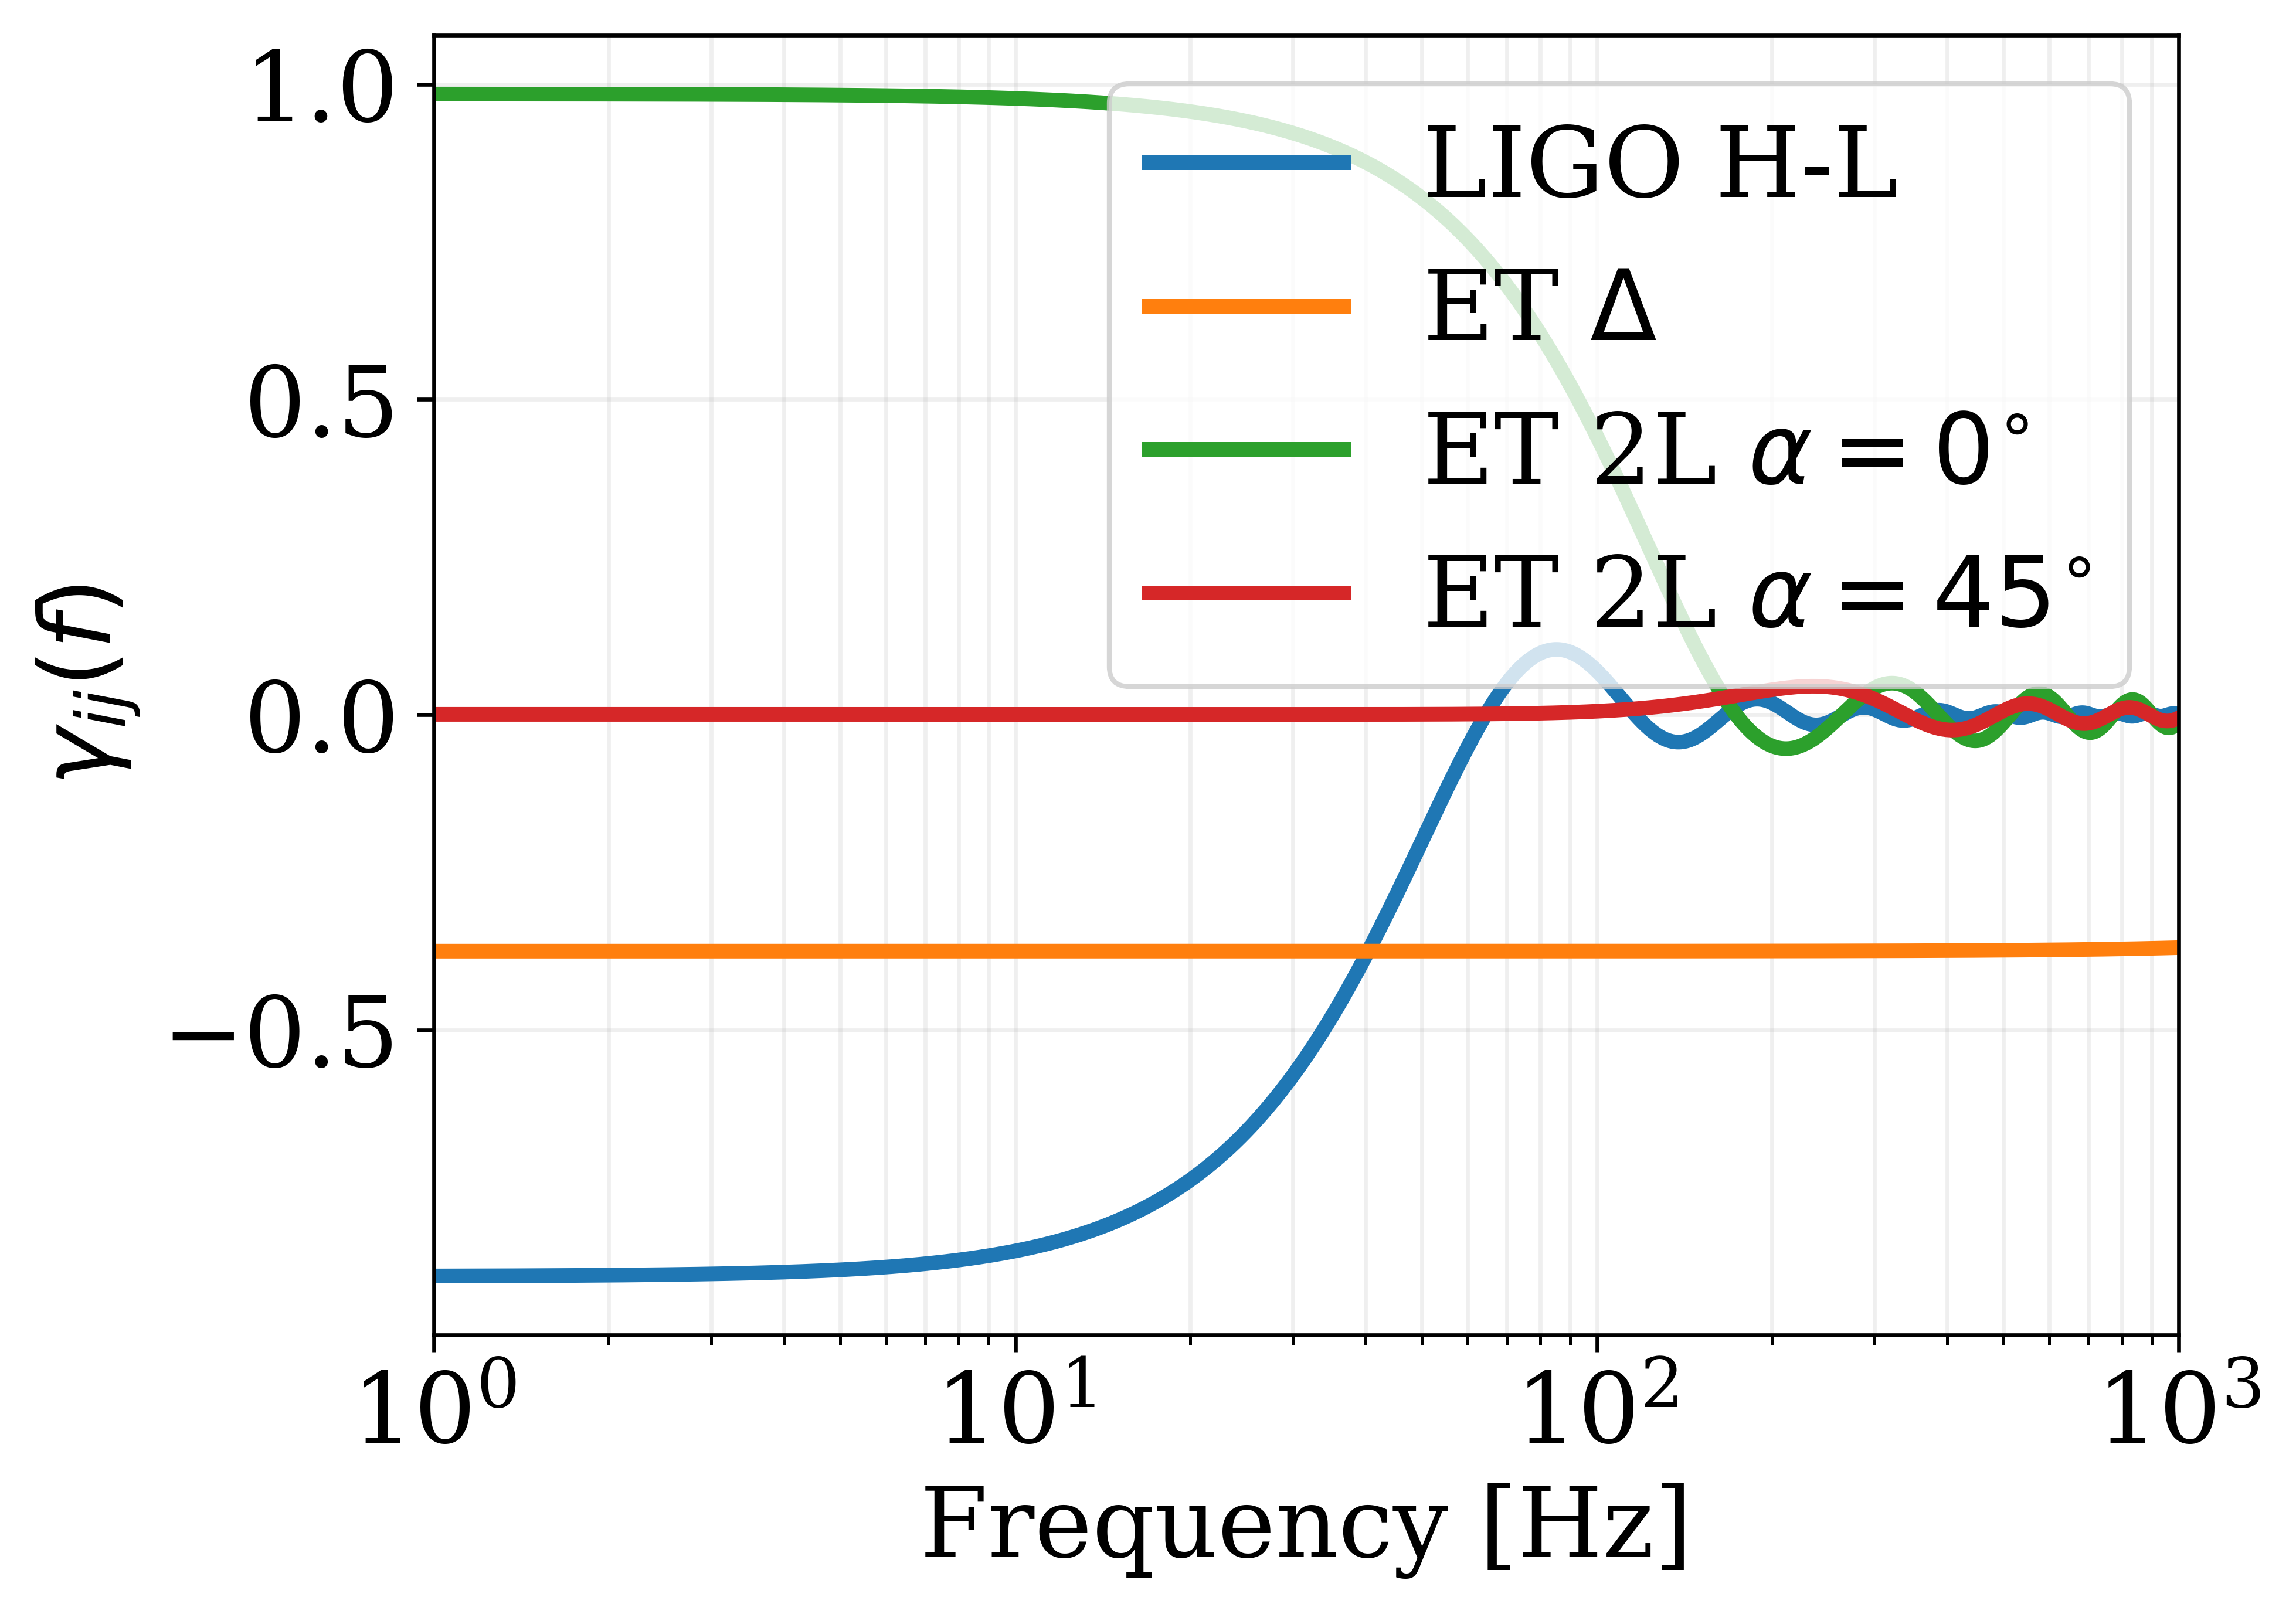

In [25]:
plt.plot(f, R_LIGO, label='LIGO H-L')
plt.plot(f, R_ET, label=r'ET $\Delta$')
plt.plot(f, R_ET2L0, label=r'ET 2L $\alpha=0^{\circ}$')
plt.plot(f, R_ET2L45, label=r'ET 2L $\alpha=45^{\circ}$')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.ylabel(r'$\gamma_{ij}(f)$')
plt.xlim(f.min(), f.max())
plt.grid(which='both', alpha=0.2) 
plt.legend()  


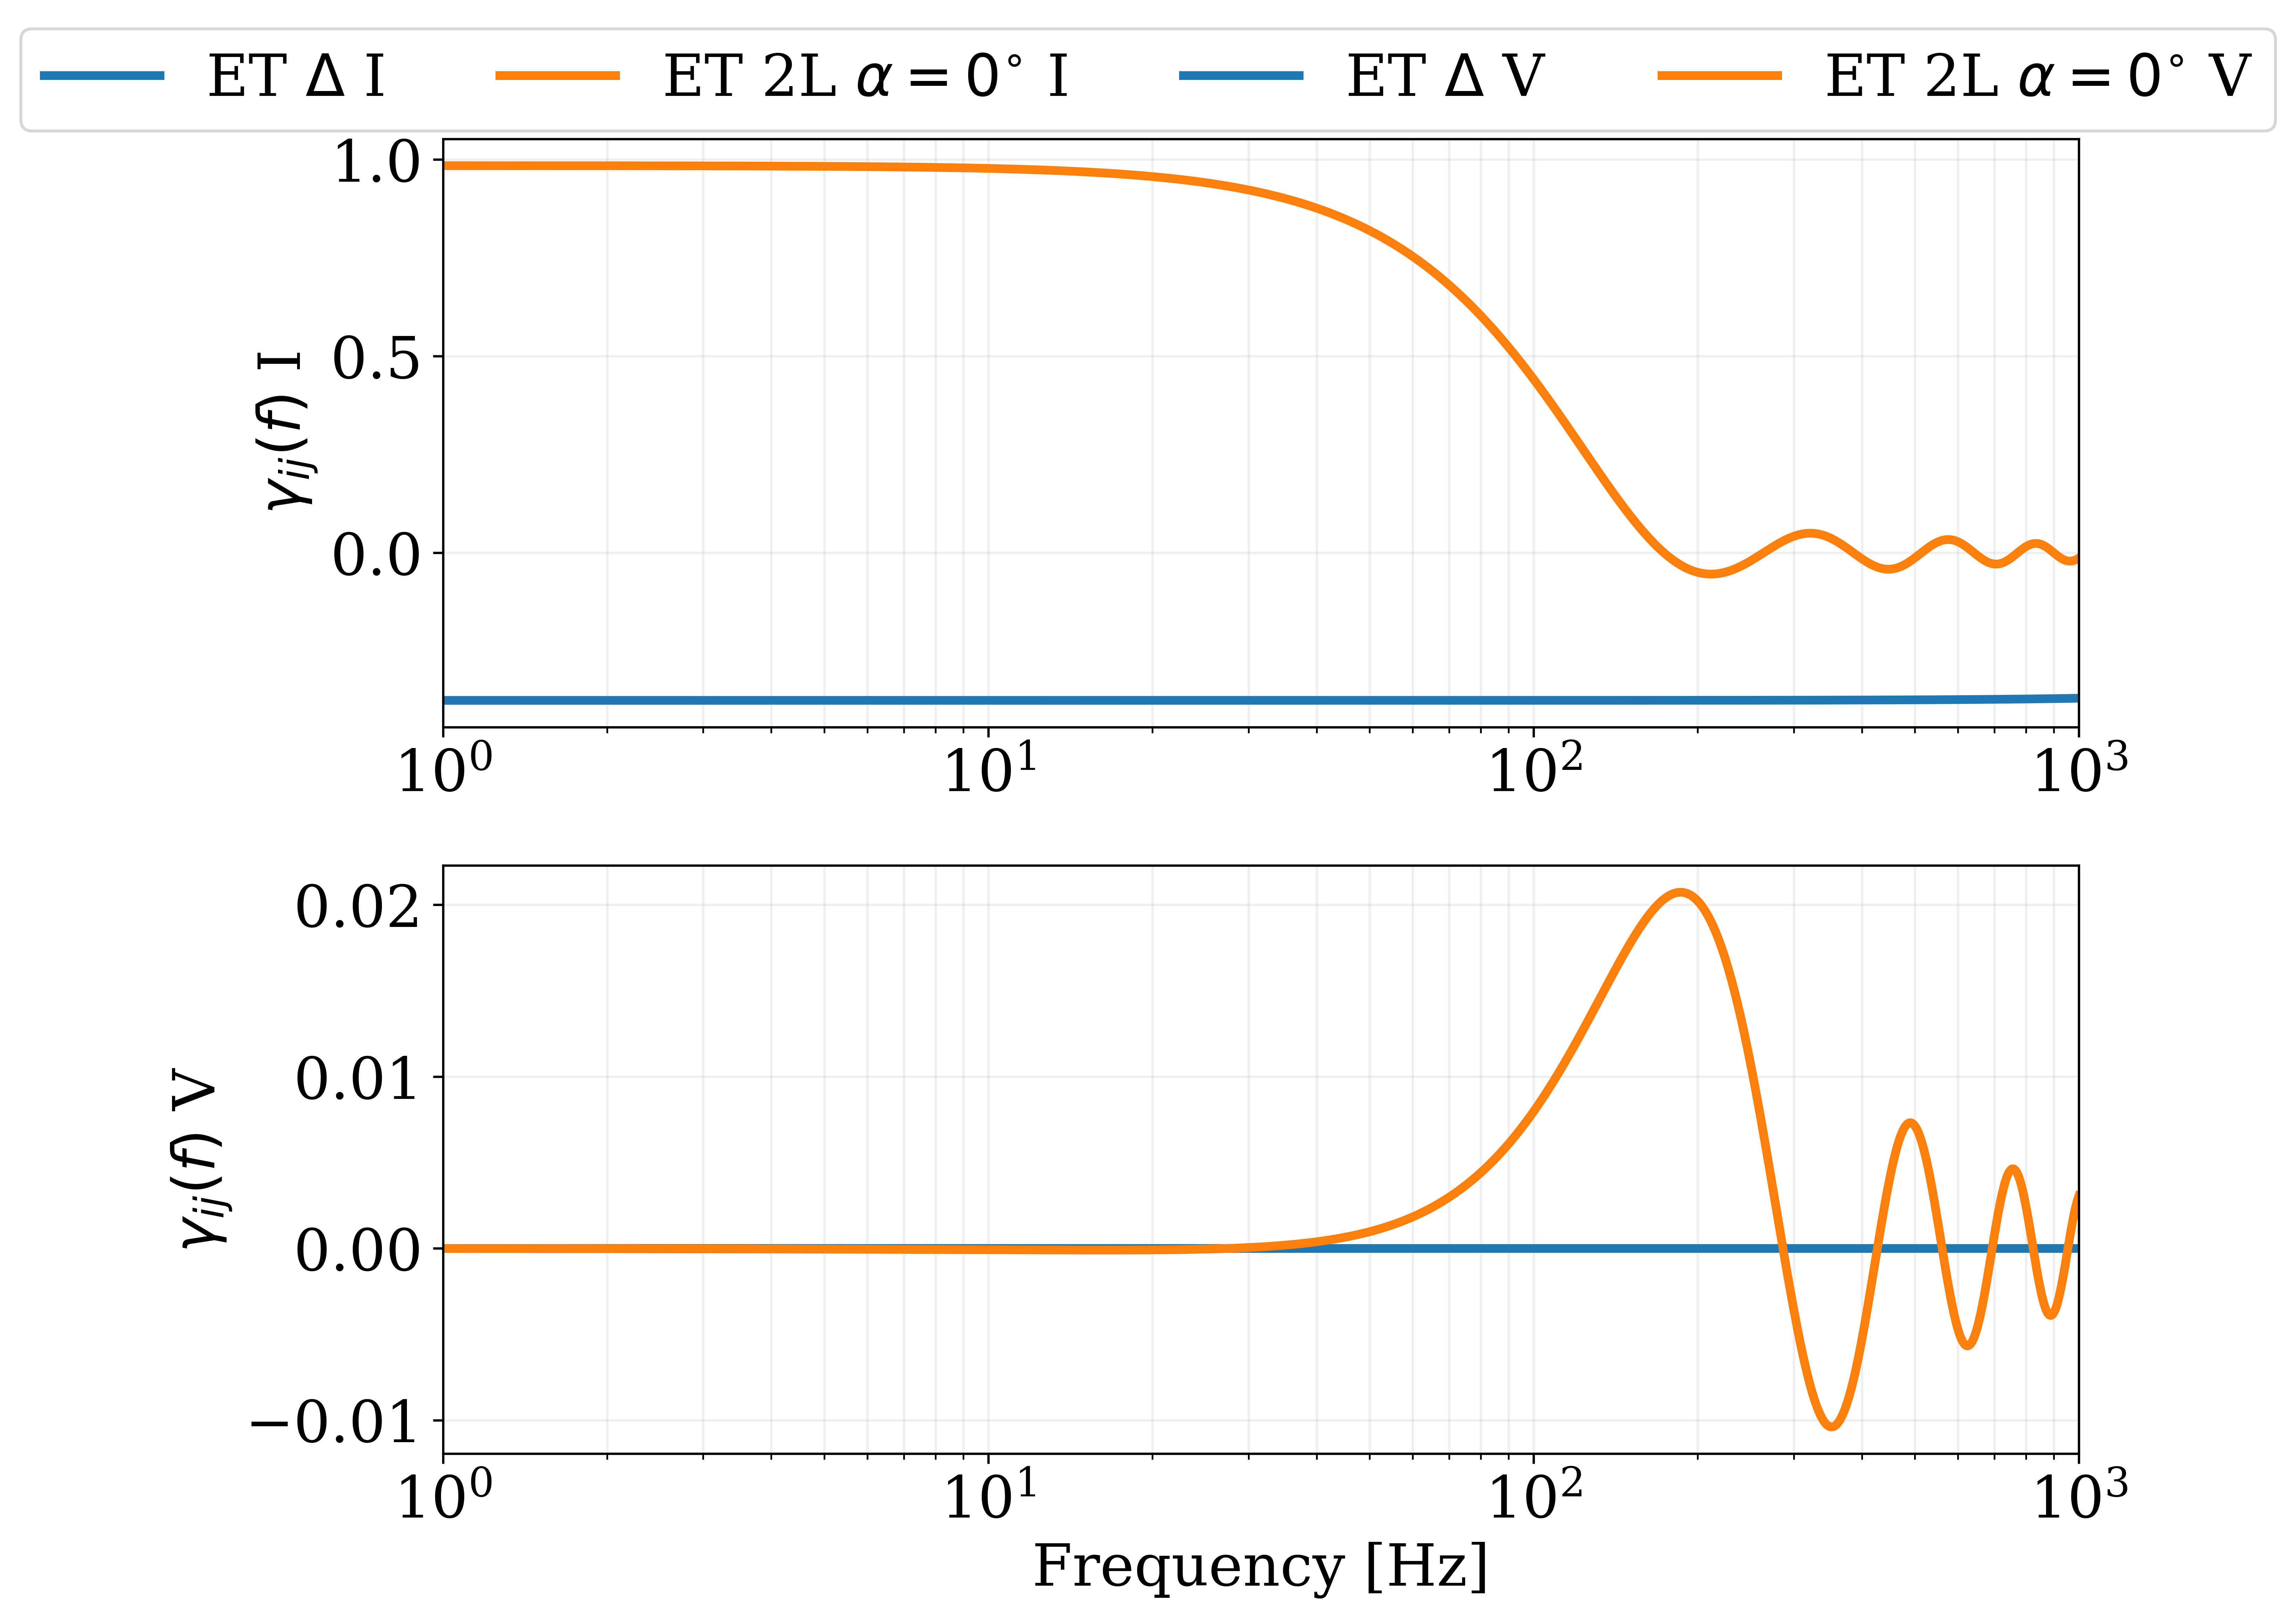

In [29]:

R_ET_I    = Response.overlap('ET X', 'ET Y', f, 0, 'I', None)
R_ET_V    = Response.overlap('ET X', 'ET Y', f, 0, 'V', None)
R_ET2L0_I = Response.overlap('ET L1', 'ET L2', f, 0, 'I', shift_angle=0)
R_ET2L0_V = Response.overlap('ET L1', 'ET L2', f, 0, 'V', shift_angle=0)


plt.figure(figsize=(10, 8))

# Primo plot per I
plt.subplot(2, 1, 1)
#plt.plot(f, R_LIGO_I, label='LIGO H-L I')
plt.plot(f, R_ET_I, label='ET $\Delta$ I')
plt.plot(f, R_ET2L0_I, label=r'ET 2L $\alpha=0^{\circ}$ I')
#plt.plot(f, R_ET2L45_I, label=r'ET 2L $\alpha=45^{\circ}$ I')
plt.xscale('log')
plt.ylabel(r'$\gamma_{ij}(f)$ I')
plt.xlim(f.min(), f.max())
plt.grid(which='both', alpha=0.2)

# Secondo plot per V
plt.subplot(2, 1, 2)
#plt.plot(f, R_LIGO_V, label='LIGO H-L V')
plt.plot(f, R_ET_V, label='ET $\Delta$ V')
plt.plot(f, R_ET2L0_V, label=r'ET 2L $\alpha=0^{\circ}$ V')
#plt.plot(f, R_ET2L45_V, label=r'ET 2L $\alpha=45^{\circ}$ V')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.ylabel(r'$\gamma_{ij}(f)$ V')
plt.xlim(f.min(), f.max())
plt.grid(which='both', alpha=0.2)

# Aggiungi una legenda sopra i plot
lines_labels = [ax.get_legend_handles_labels() for ax in plt.gcf().axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
plt.figlegend(lines, labels, loc='upper center', ncol=4)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [23]:
print(R_ET_V[:10] )
print(R_ET2L0_V[:10] )

[ 0.00000000e+00  5.55111512e-17 -5.55111512e-17  5.55111512e-17
 -5.55111512e-17  0.00000000e+00  1.11022302e-16  0.00000000e+00
  5.55111512e-17 -5.55111512e-17]
[-6.93889390e-18 -1.73472348e-18 -8.67361738e-19 -1.73472348e-18
 -2.60208521e-18  0.00000000e+00  1.73472348e-18  0.00000000e+00
 -8.67361738e-19  8.67361738e-19]


## LISA

* Note: we do not adopt the convention by which $\gamma_{ij}$ is normalized by $1/4\pi$ for LISA but we normalize it as all the other detectors to $5/8\pi$

1.1247638531600688


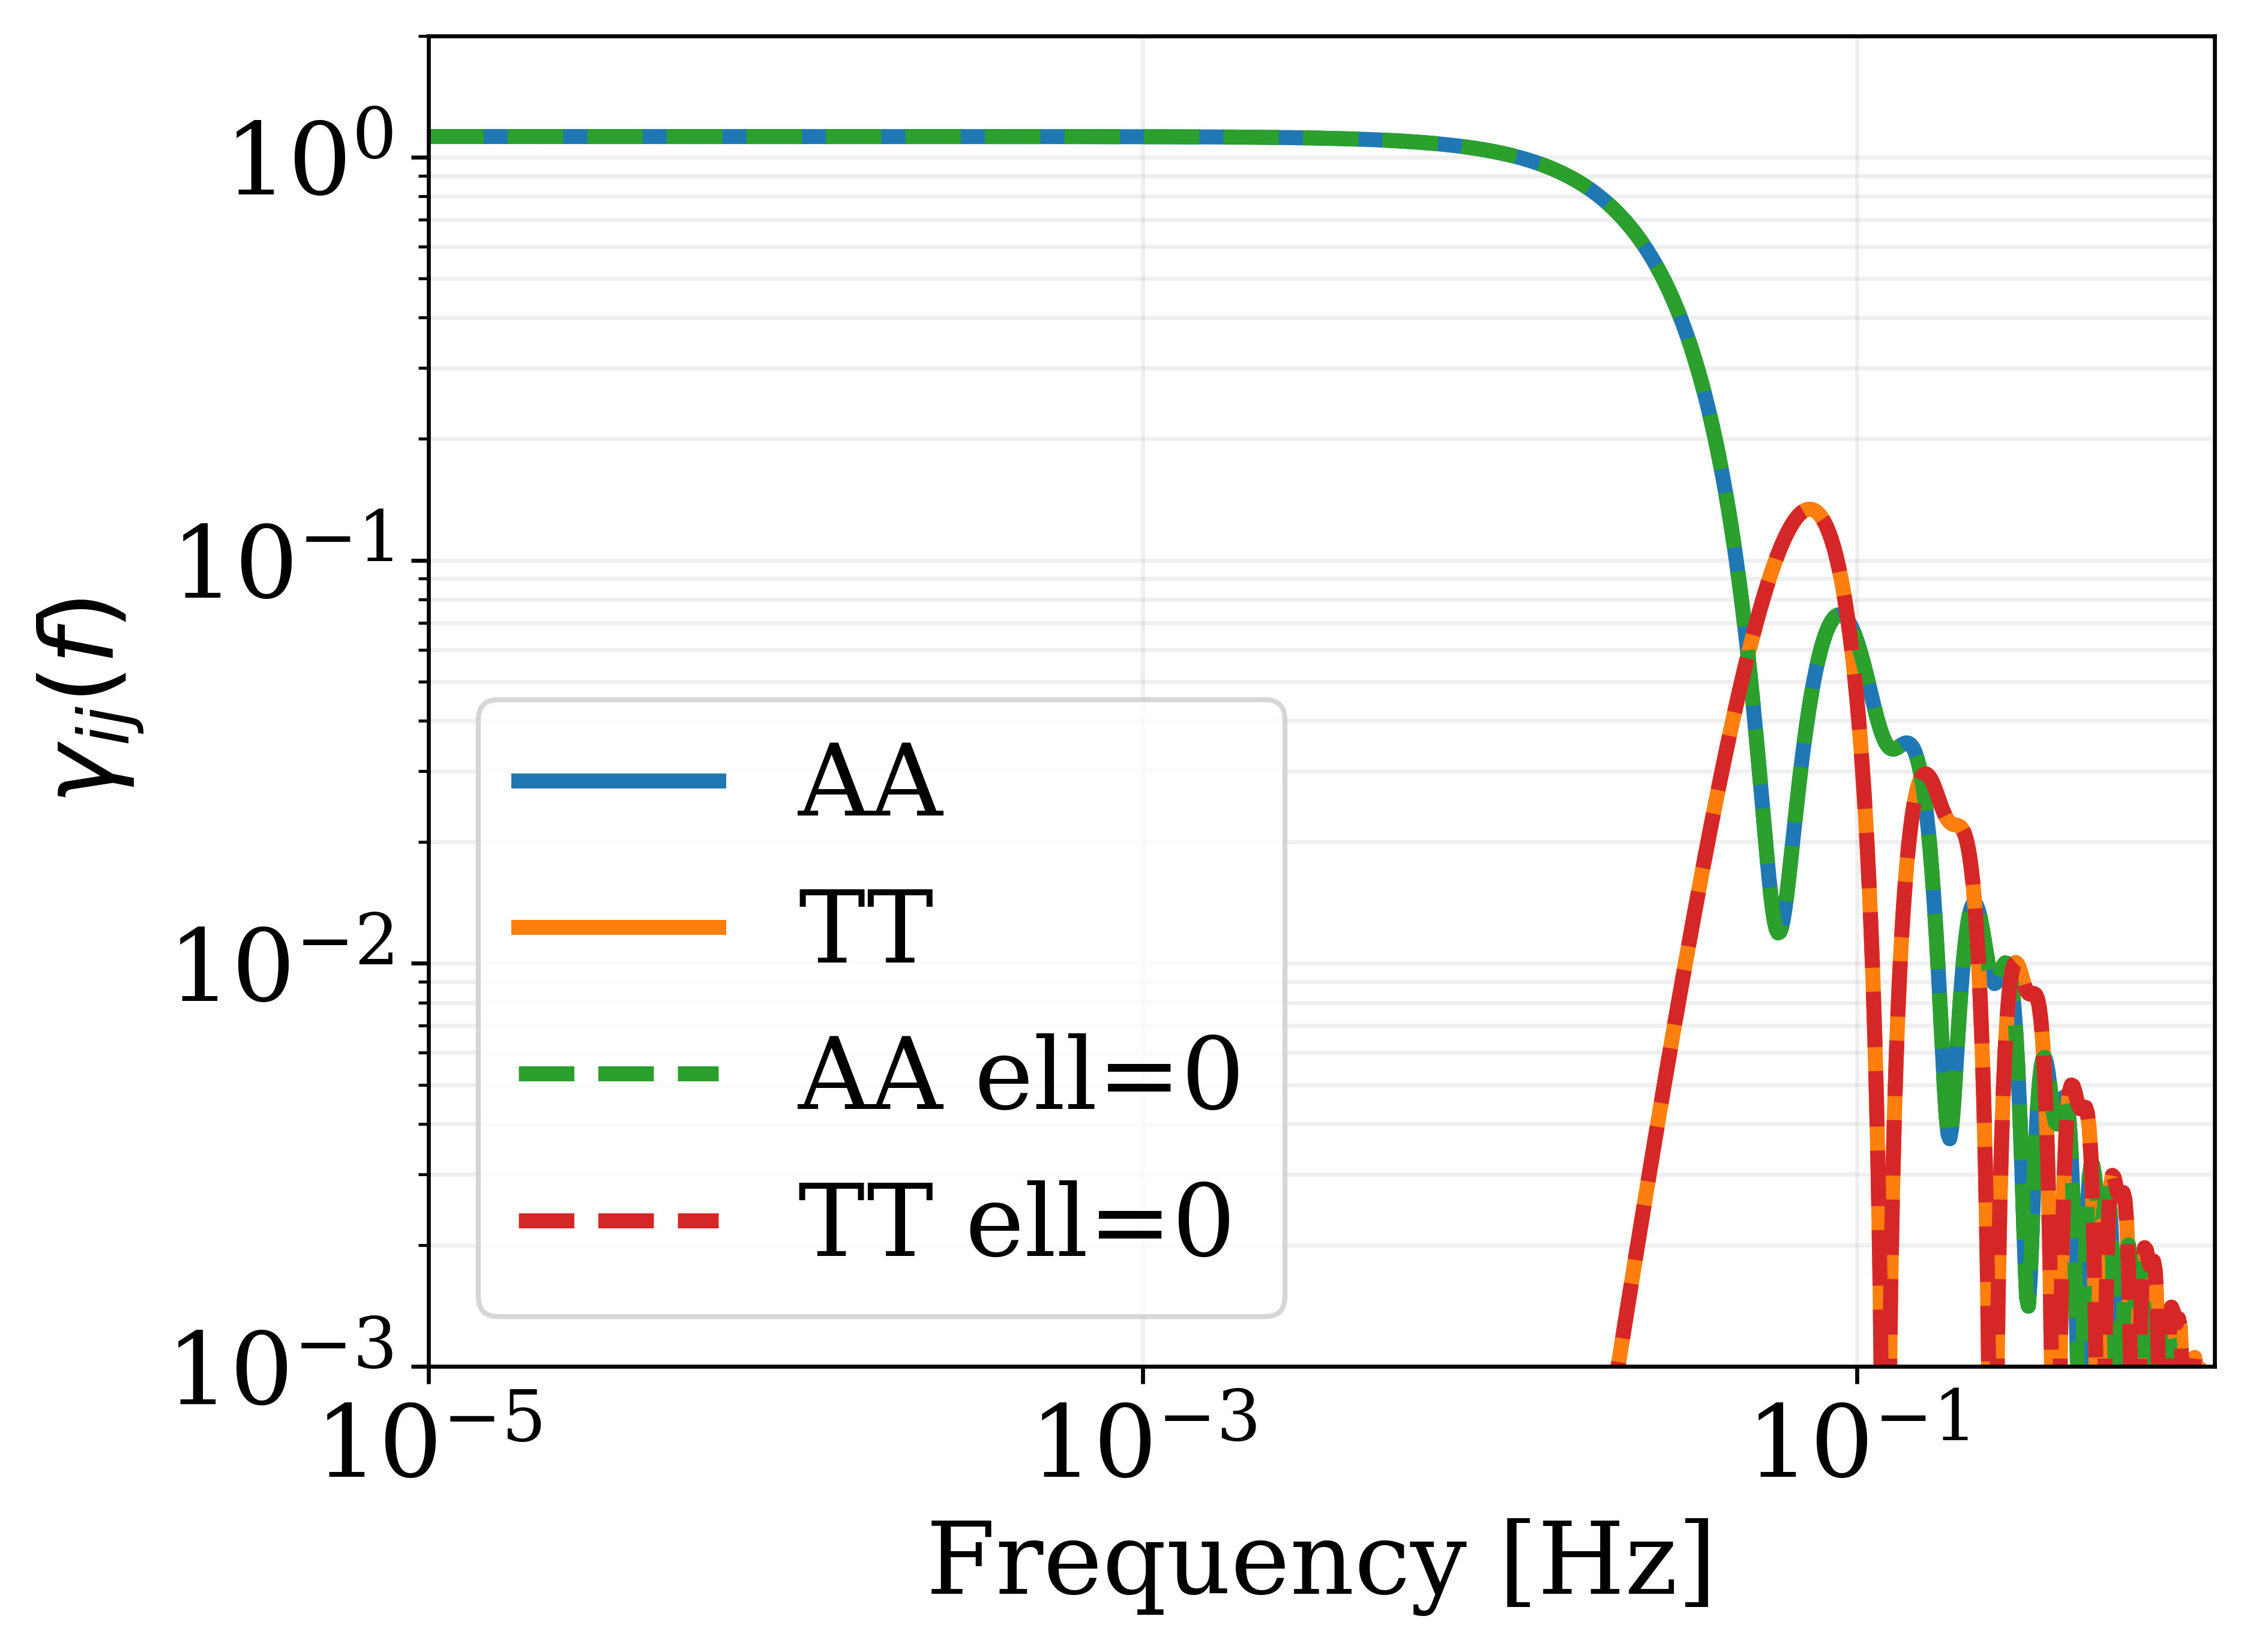

In [6]:
f_lisa = np.logspace(-5, 0, 1000)
# R_XX = Response.overlap('LISA X', 'LISA X', f_lisa, 0, 't')
# R_XY = Response.overlap('LISA X', 'LISA Y', f_lisa, 0, 't')
R_AA = Response.overlap('LISA A', 'LISA A', f_lisa, 0, 't')
R_TT = Response.overlap('LISA T', 'LISA T', f_lisa, 0, 't')
# test to see if the angular at ell=0 math che overlap
R0_LISA_AA = AngularResponse.R_ell(0,'LISA A', 'LISA A', f_lisa, 't', 0)
R0_LISA_TT = AngularResponse.R_ell(0,'LISA T', 'LISA T', f_lisa, 't', 0)

# print(R_XX[0])
# print(R_XY[0])
print(R_AA[0])

plt.figure()
# plt.plot(f_lisa, R_XX, label='auto')
# plt.plot(f_lisa, R_XY, label='cross')
plt.plot(f_lisa, R_AA, label='AA')
plt.plot(f_lisa, R_TT, label='TT')
plt.plot(f_lisa, R0_LISA_AA, label='AA ell=0', linestyle='--')
plt.plot(f_lisa, R0_LISA_TT, label='TT ell=0', linestyle='--')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\gamma_{ij}(f)$')
plt.xlim(f_lisa.min(), f_lisa.max())
plt.ylim(1e-3, 2)
plt.grid(which='both', alpha=0.2)
plt.legend()

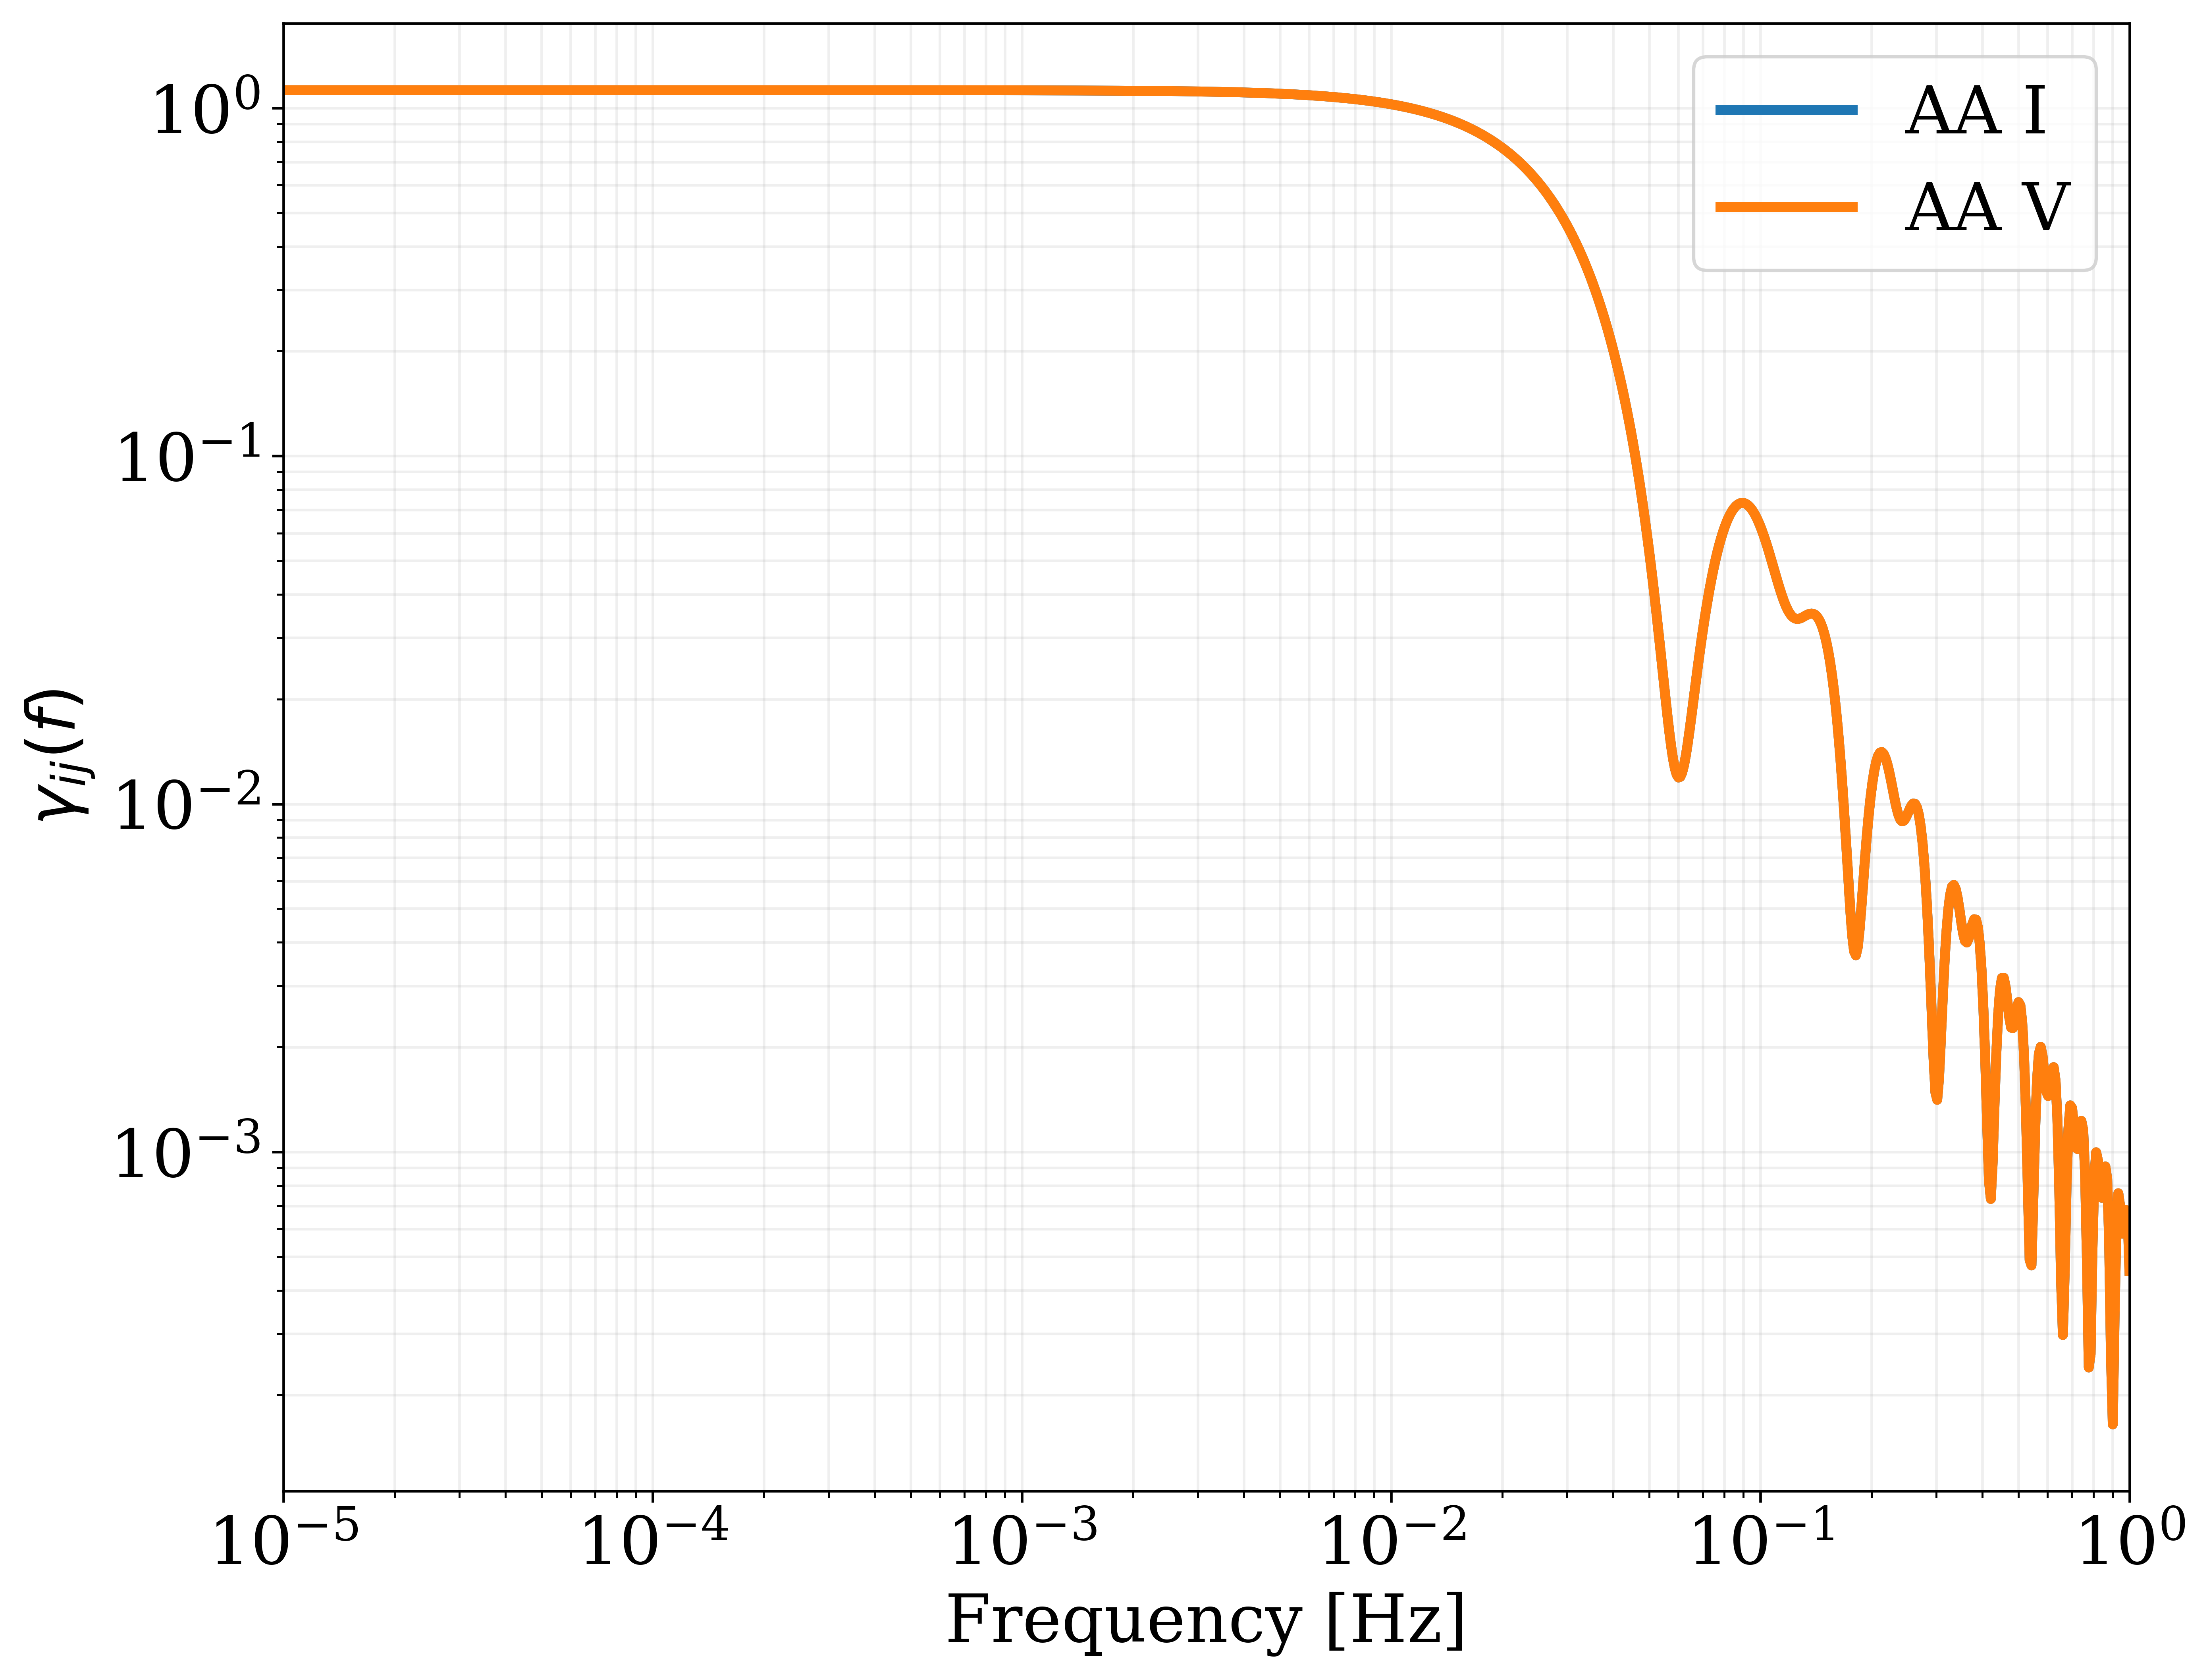

In [7]:
R_AA_I = Response.overlap('LISA A', 'LISA A', f_lisa, 0, 't', None, 'I')
R_AA_V = Response.overlap('LISA A', 'LISA A', f_lisa, 0, 't', None, 'V')

plt.figure(figsize=(10, 8))
plt.plot(f_lisa, R_AA_I, label='AA I')
plt.plot(f_lisa, R_AA_V, label='AA V')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\gamma_{ij}(f)$')
plt.xlim(f_lisa.min(), f_lisa.max())
plt.grid(which='both', alpha=0.2)
plt.legend()

# Power law integrated sensitivity curve


## Ground Based Detectors


Evaluate the sensitivity of a couple of detector to a GWB signal.

sens = pls.PLS(det1, det2, f, fref, pol, snr, Tobs, beta_min, beta_max, psi, shift_angle, fI=None, PnI=None, fJ=None, PnJ=None)

Parameters:

- det1, det2: str or list of str
    The name of the detector(s) to consider.
    The names must be in the list of detectors available in the response module.
    The list of available detectors can be obtained by calling the function detectors.available_detectors().
    The names of the detectors are case sensitive.
    If you want to provide a custom detector, you can provide the following information in a list:

    H = [c, xA, xB, l, name]

    - c: array_like of length 3 (Position of the detector in the Earth-centered frame in meters)
    - xA: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - xB: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - l: float (Length of the arm in meters)
    - name: str (Name of the detector)

- f = array_like (Frequency in Hz)
- fref = float (Reference frequency in Hz)
- pol = str (Polarization of the signal, 't' for tensor, 'v' for vector, 's' for scalar)
- snr = float (Signal-to-noise ratio threshold)
- Tobs = float (Observation time in years)
- beta_min = float (Minimum tilt to consider)
- beta_max = float (Maximum tilt to consider)
- psi = float (Polarization angle in radians)


Optional parameters:
- shift_angle = bool or float (Shift the angle of the response if considering ET 2L in radians)
- fI = bool or array_like (Frequency in Hz for the detector I)
- PnI = bool or array_like (Power spectral density for the detector I)
- fJ = bool or array_like (Frequency in Hz for the detector J)
- PnJ = bool or array_like (Power spectral density for the detector J)




In [197]:
snr = 1
Tobs = 1
psi = 0
shift_angle = False
fref = 10

sens_LIGO = pls.PLS('LIGO H', 'LIGO L', f, fref, 't', snr, Tobs, psi)
sens_ET = pls.PLS('ET X', 'ET Y', f, fref, 't', snr, Tobs, psi)
sens_ET_network = pls.PLS('ET triangular', 'Network', f, fref, 't', snr, Tobs, psi)
sens_ET2L0 = pls.PLS('ET L1', 'ET L2', f, fref, 't', snr, Tobs, psi, shift_angle=0)
sens_ET2L45 = pls.PLS('ET L1', 'ET L2', f, fref, 't', snr, Tobs, psi, shift_angle=np.pi/4)



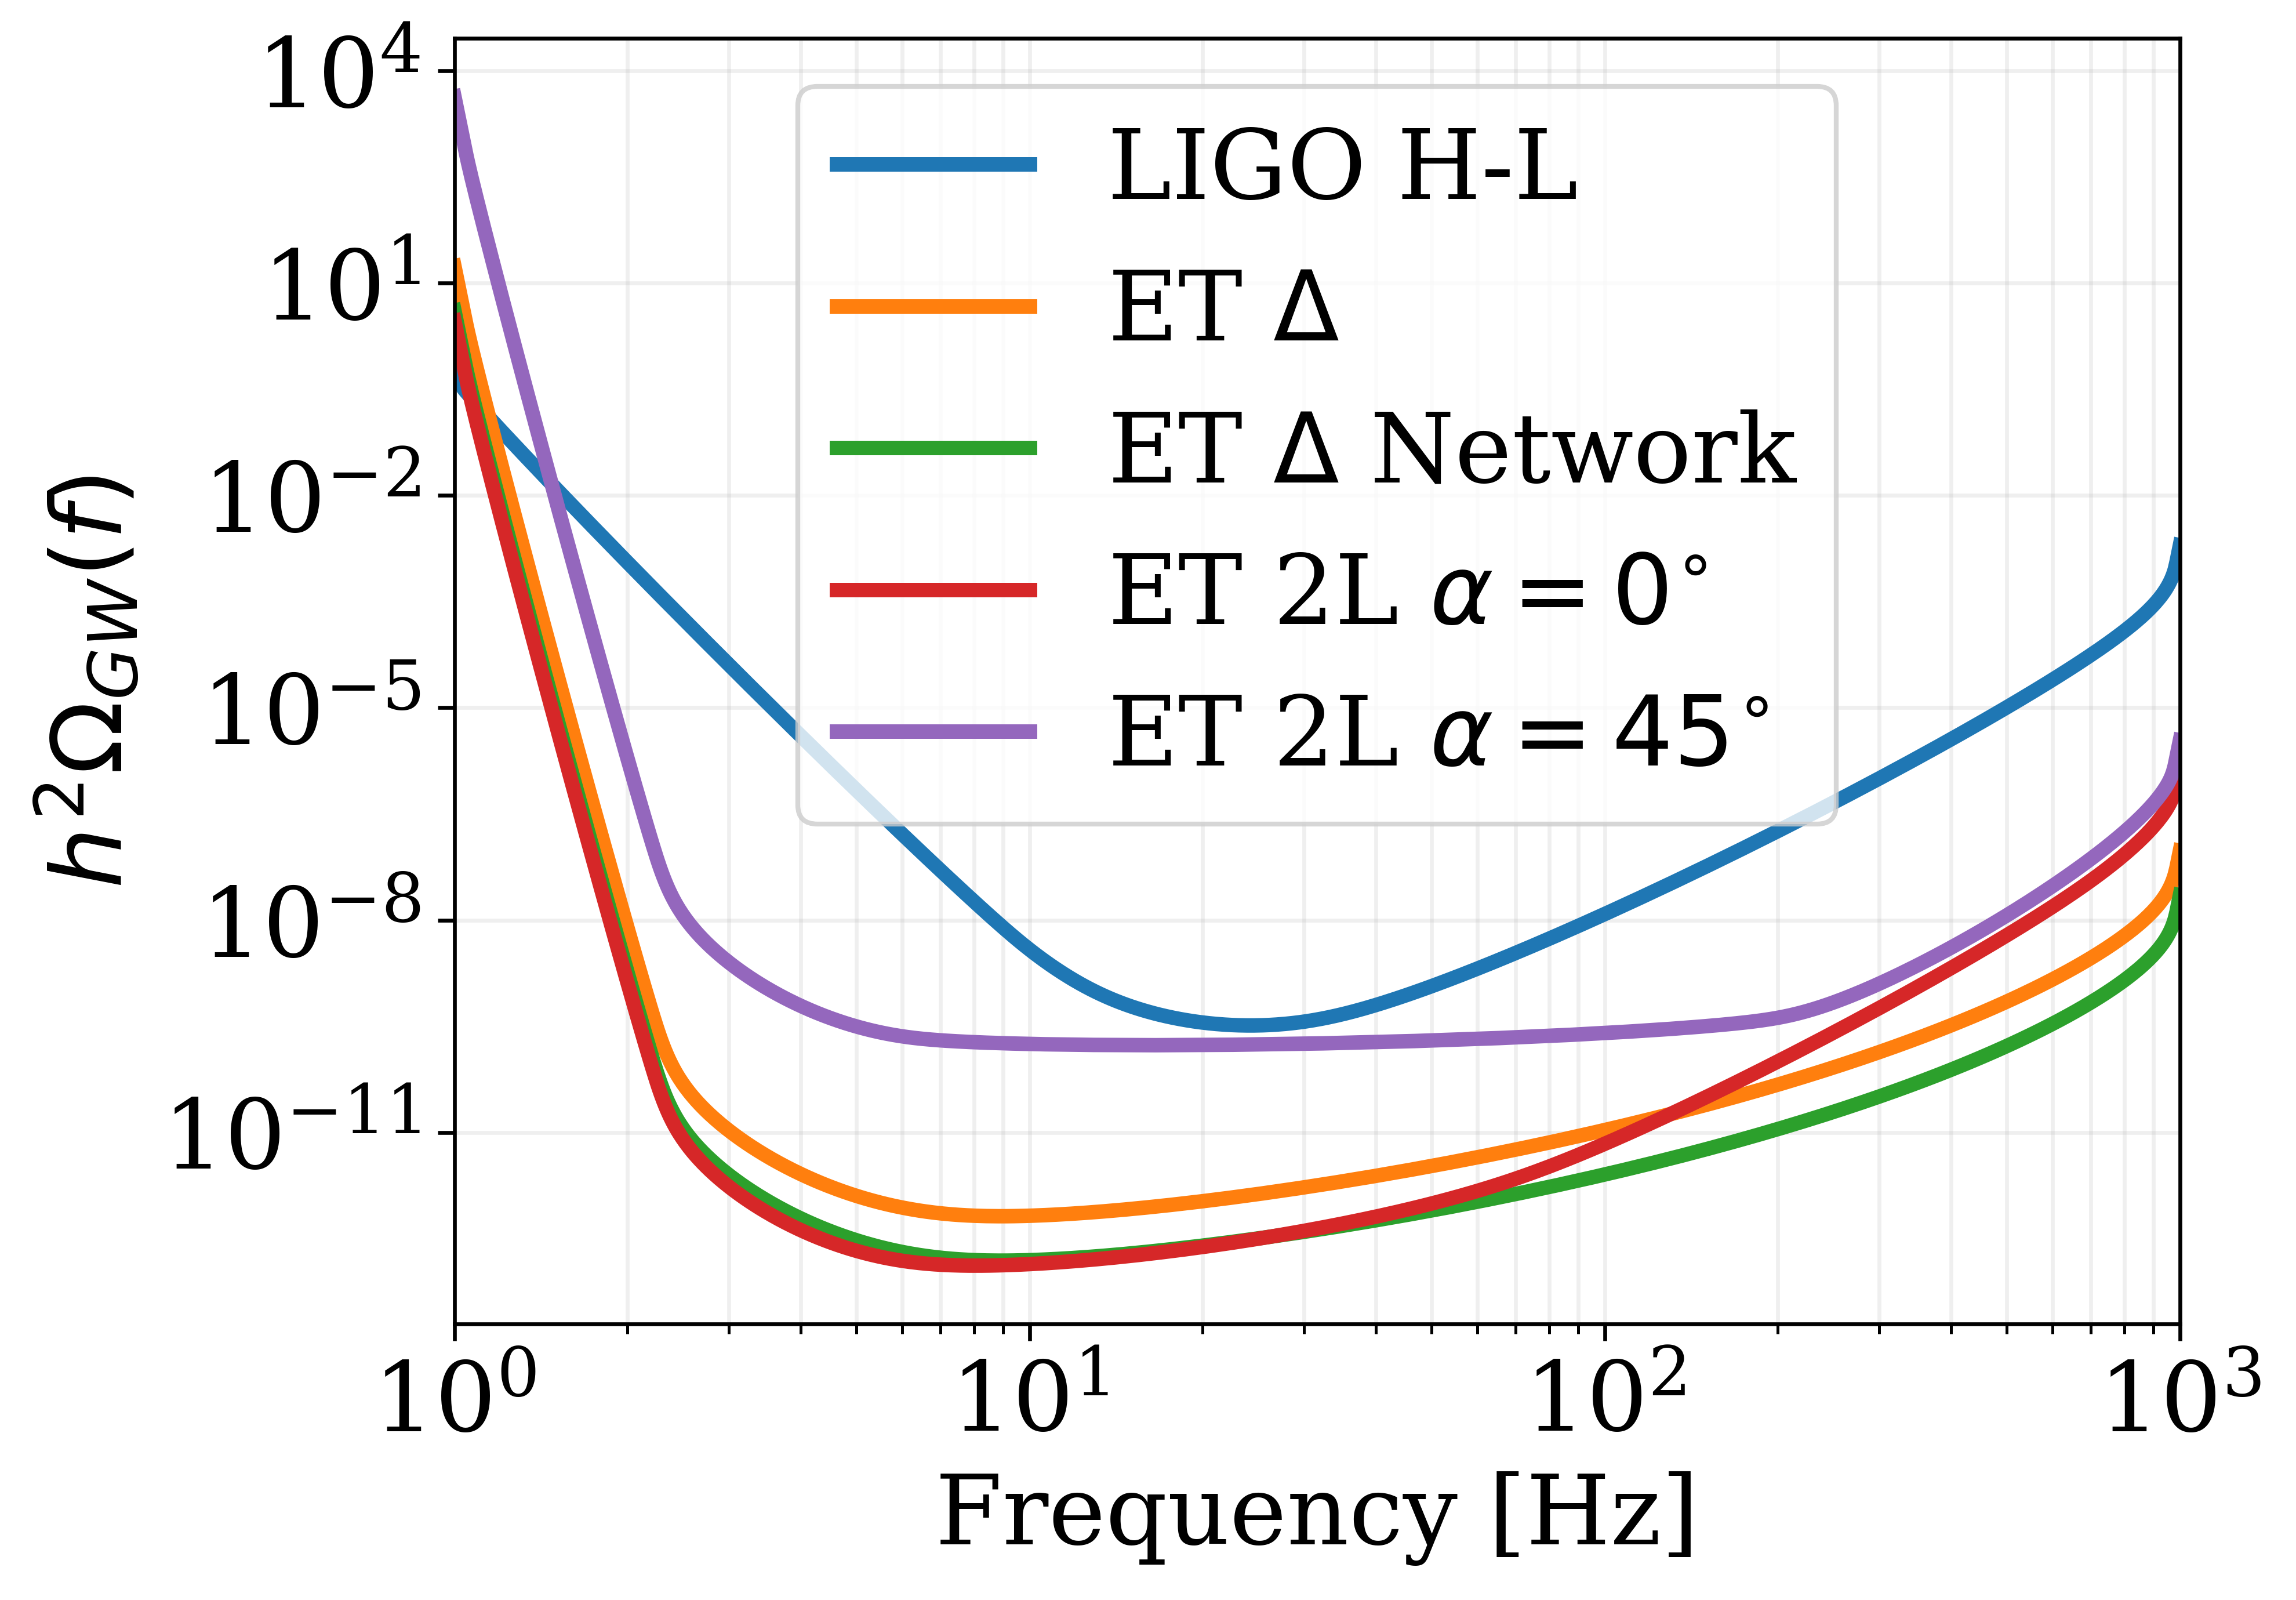

In [198]:
plt.plot(f, sens_LIGO, label='LIGO H-L')
plt.plot(f, sens_ET, label=r'ET $\Delta$')
plt.plot(f, sens_ET_network, label=r'ET $\Delta$ Network')
plt.plot(f, sens_ET2L0, label=r'ET 2L $\alpha=0^{\circ}$')
plt.plot(f, sens_ET2L45, label=r'ET 2L $\alpha=45^{\circ}$')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$h^2 \Omega_{GW}(f)$')
plt.xlim(f.min(), f.max())
plt.grid(which='both', alpha=0.2)
plt.legend()  



In [201]:
print(sens_ET.min()/(3))
print(sens_ET_network.min())



2.1802126675036e-13
1.5416431616206063e-13


## LISA

/Users/ic/Desktop/GWBird/gwbird/pls.py:60: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt(Ni * Nj) / np.abs(orf)


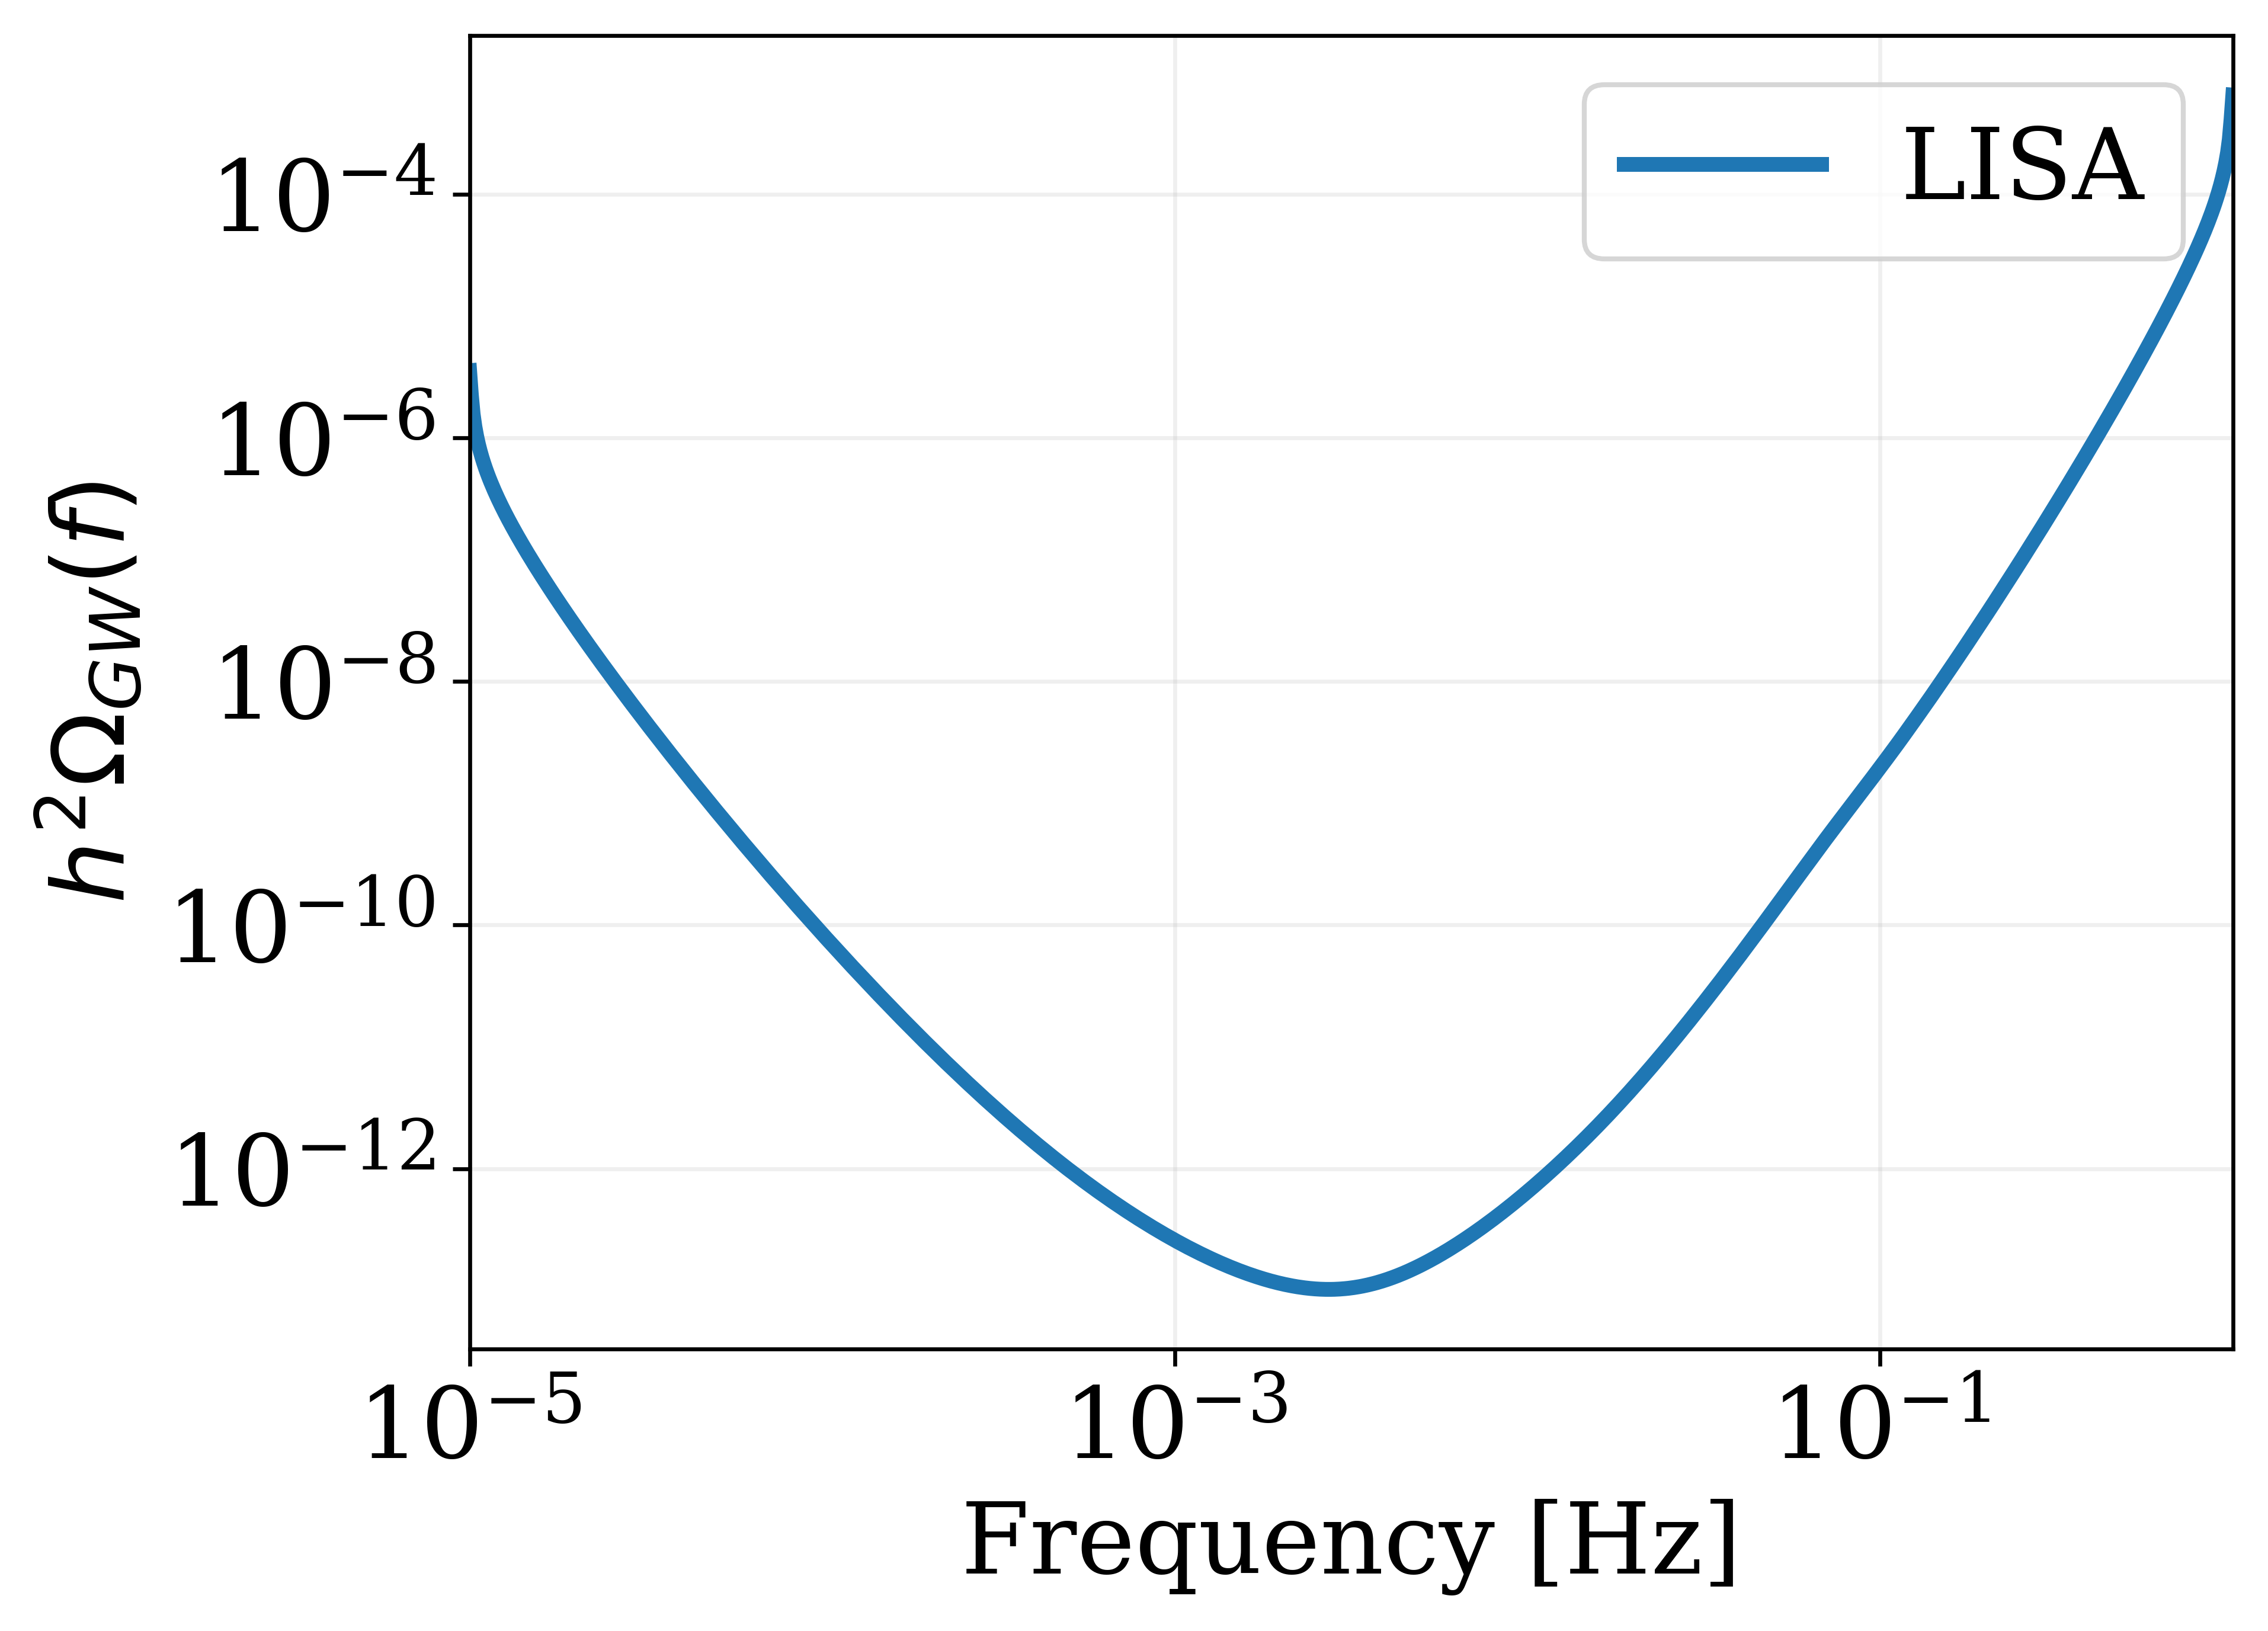

In [202]:
snr = 10
Tobs = 3
psi = 0
fref = 1e-2

sens_LISA_network = pls.PLS('LISA', 'Network', f_lisa, fref, 't', snr, Tobs, psi)

plt.figure()
plt.plot(f_lisa, sens_LISA_network, label='LISA')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$h^2 \Omega_{GW}(f)$')
plt.xlim(f_lisa.min(), f_lisa.max())
plt.grid(which='both', alpha=0.2)
plt.legend()


In [203]:
print(sens_LISA_network.min())

1.019226599636478e-13


# Angular Response

## Ground Based Detectors

Calculate the angular response of a detector to a GWB signal for a specific multipole ell.

R_ell = AngularResponse.R_ell( ell, det1, det2, f, pol, psi, shift_angle=False)

Parameters:
- ell: int positive (Multipole to consider)
- det1, det2: str or list of str
    The name of the detector(s) to consider.
    The names must be in the list of detectors available in the response module.
    The list of available detectors can be obtained by calling the function detectors.available_detectors().
    The names of the detectors are case sensitive.
    If you want to provide a custom detector, you can provide the following information in a list:

    H = [c, xA, xB, l, name]

    - c: array_like of length 3 (Position of the detector in the Earth-centered frame in meters)
    - xA: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - xB: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - l: float (Length of the arm in meters)
    - name: str (Name of the detector)

- f: array_like (Frequency in Hz)
- pol: str (Polarization of the signal, 't' for tensor, 'v' for vector, 's' for scalar)
- psi: float (Polarization angle in radians)

Optional parameters:

- shift_angle: bool or float (Shift the angle of the response if considering ET 2L in radians)


In [180]:
ell = 2
R2_LIGO = AngularResponse.R_ell(ell, 'LIGO H', 'LIGO L', f, 't', 0)
R2_ET = AngularResponse.R_ell(ell, 'ET X', 'ET Y', f, 't', 0)
R2_ET2L0 = AngularResponse.R_ell(ell, 'ET L1', 'ET L2', f, 't', 0, shift_angle=0)
R2_ET2L45 = AngularResponse.R_ell(ell, 'ET L1', 'ET L2', f, 't', 0, shift_angle=np.pi/4)

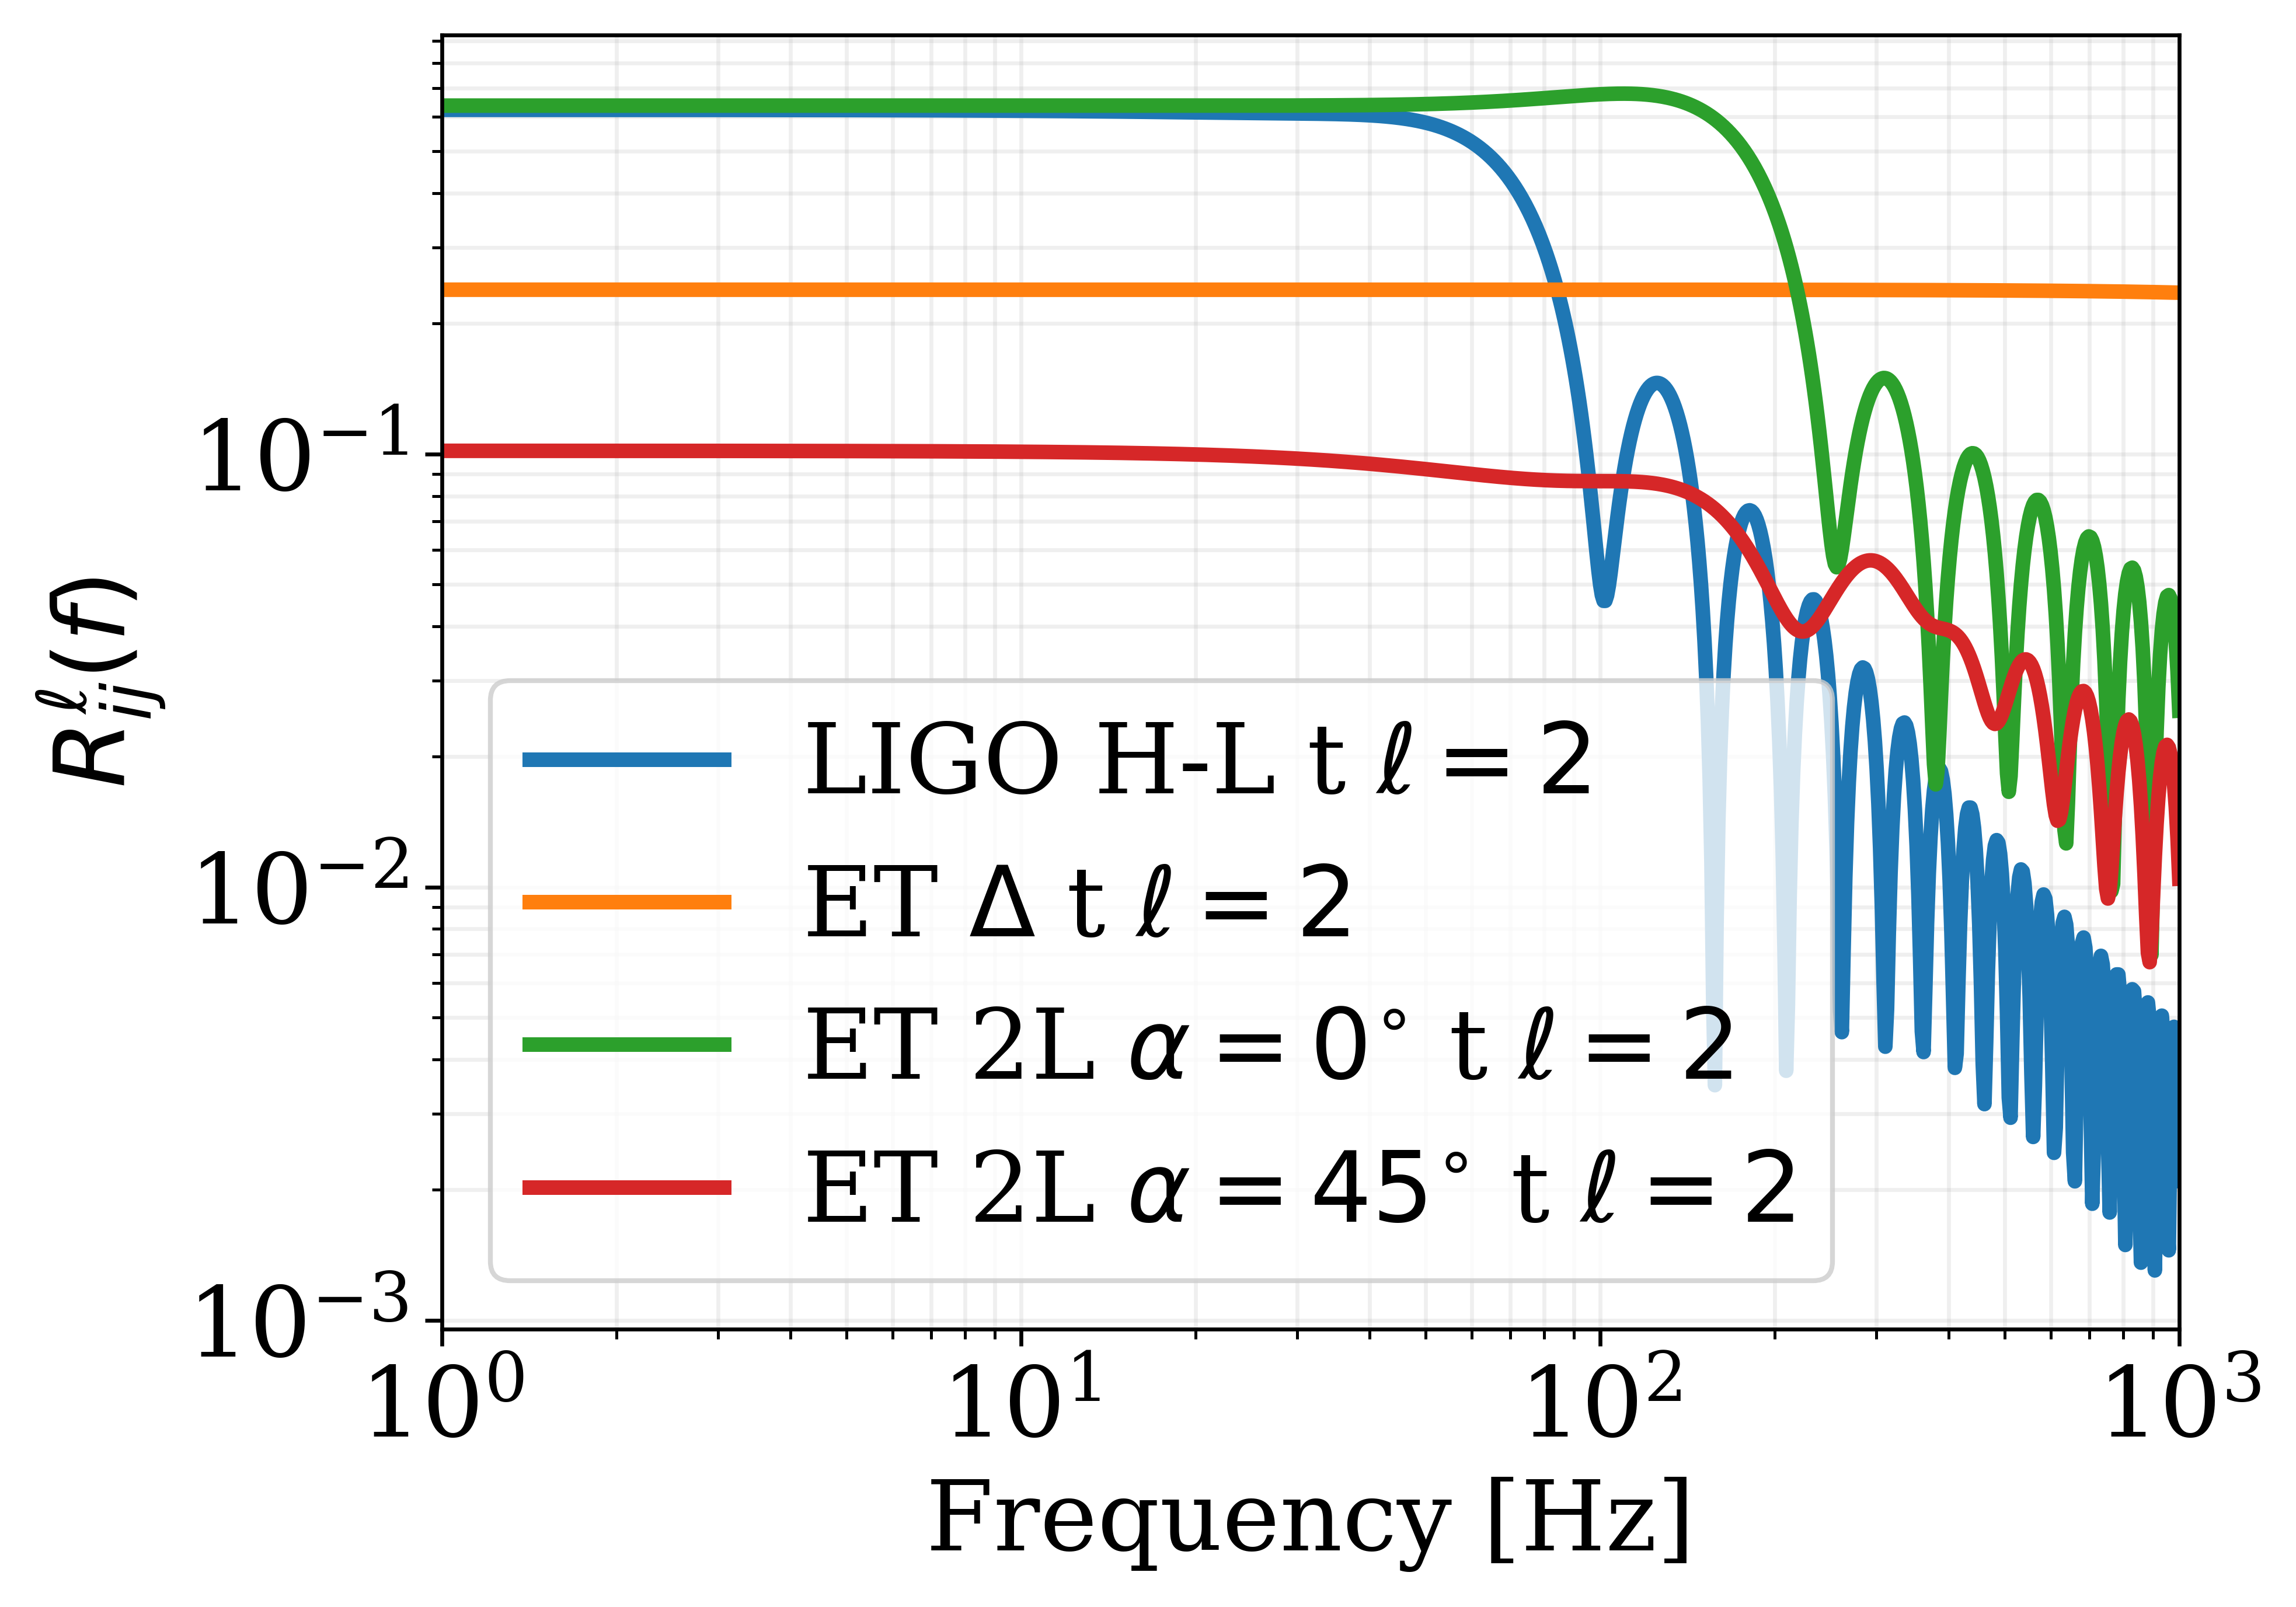

In [181]:
plt.plot(f, R2_LIGO, label=r'LIGO H-L t $\ell=2$')
plt.plot(f, R2_ET, label=r'ET $\Delta$ t $\ell=2$')
plt.plot(f, R2_ET2L0, label=r'ET 2L $\alpha=0^{\circ}$ t $\ell=2$')
plt.plot(f, R2_ET2L45, label=r'ET 2L $\alpha=45^{\circ}$ t $\ell=2$')

plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$R_{ij}^{\ell}(f)$')
plt.xlim(f.min(), f.max())
plt.grid(which='both', alpha=0.2)
plt.legend()  


# ET AET basis

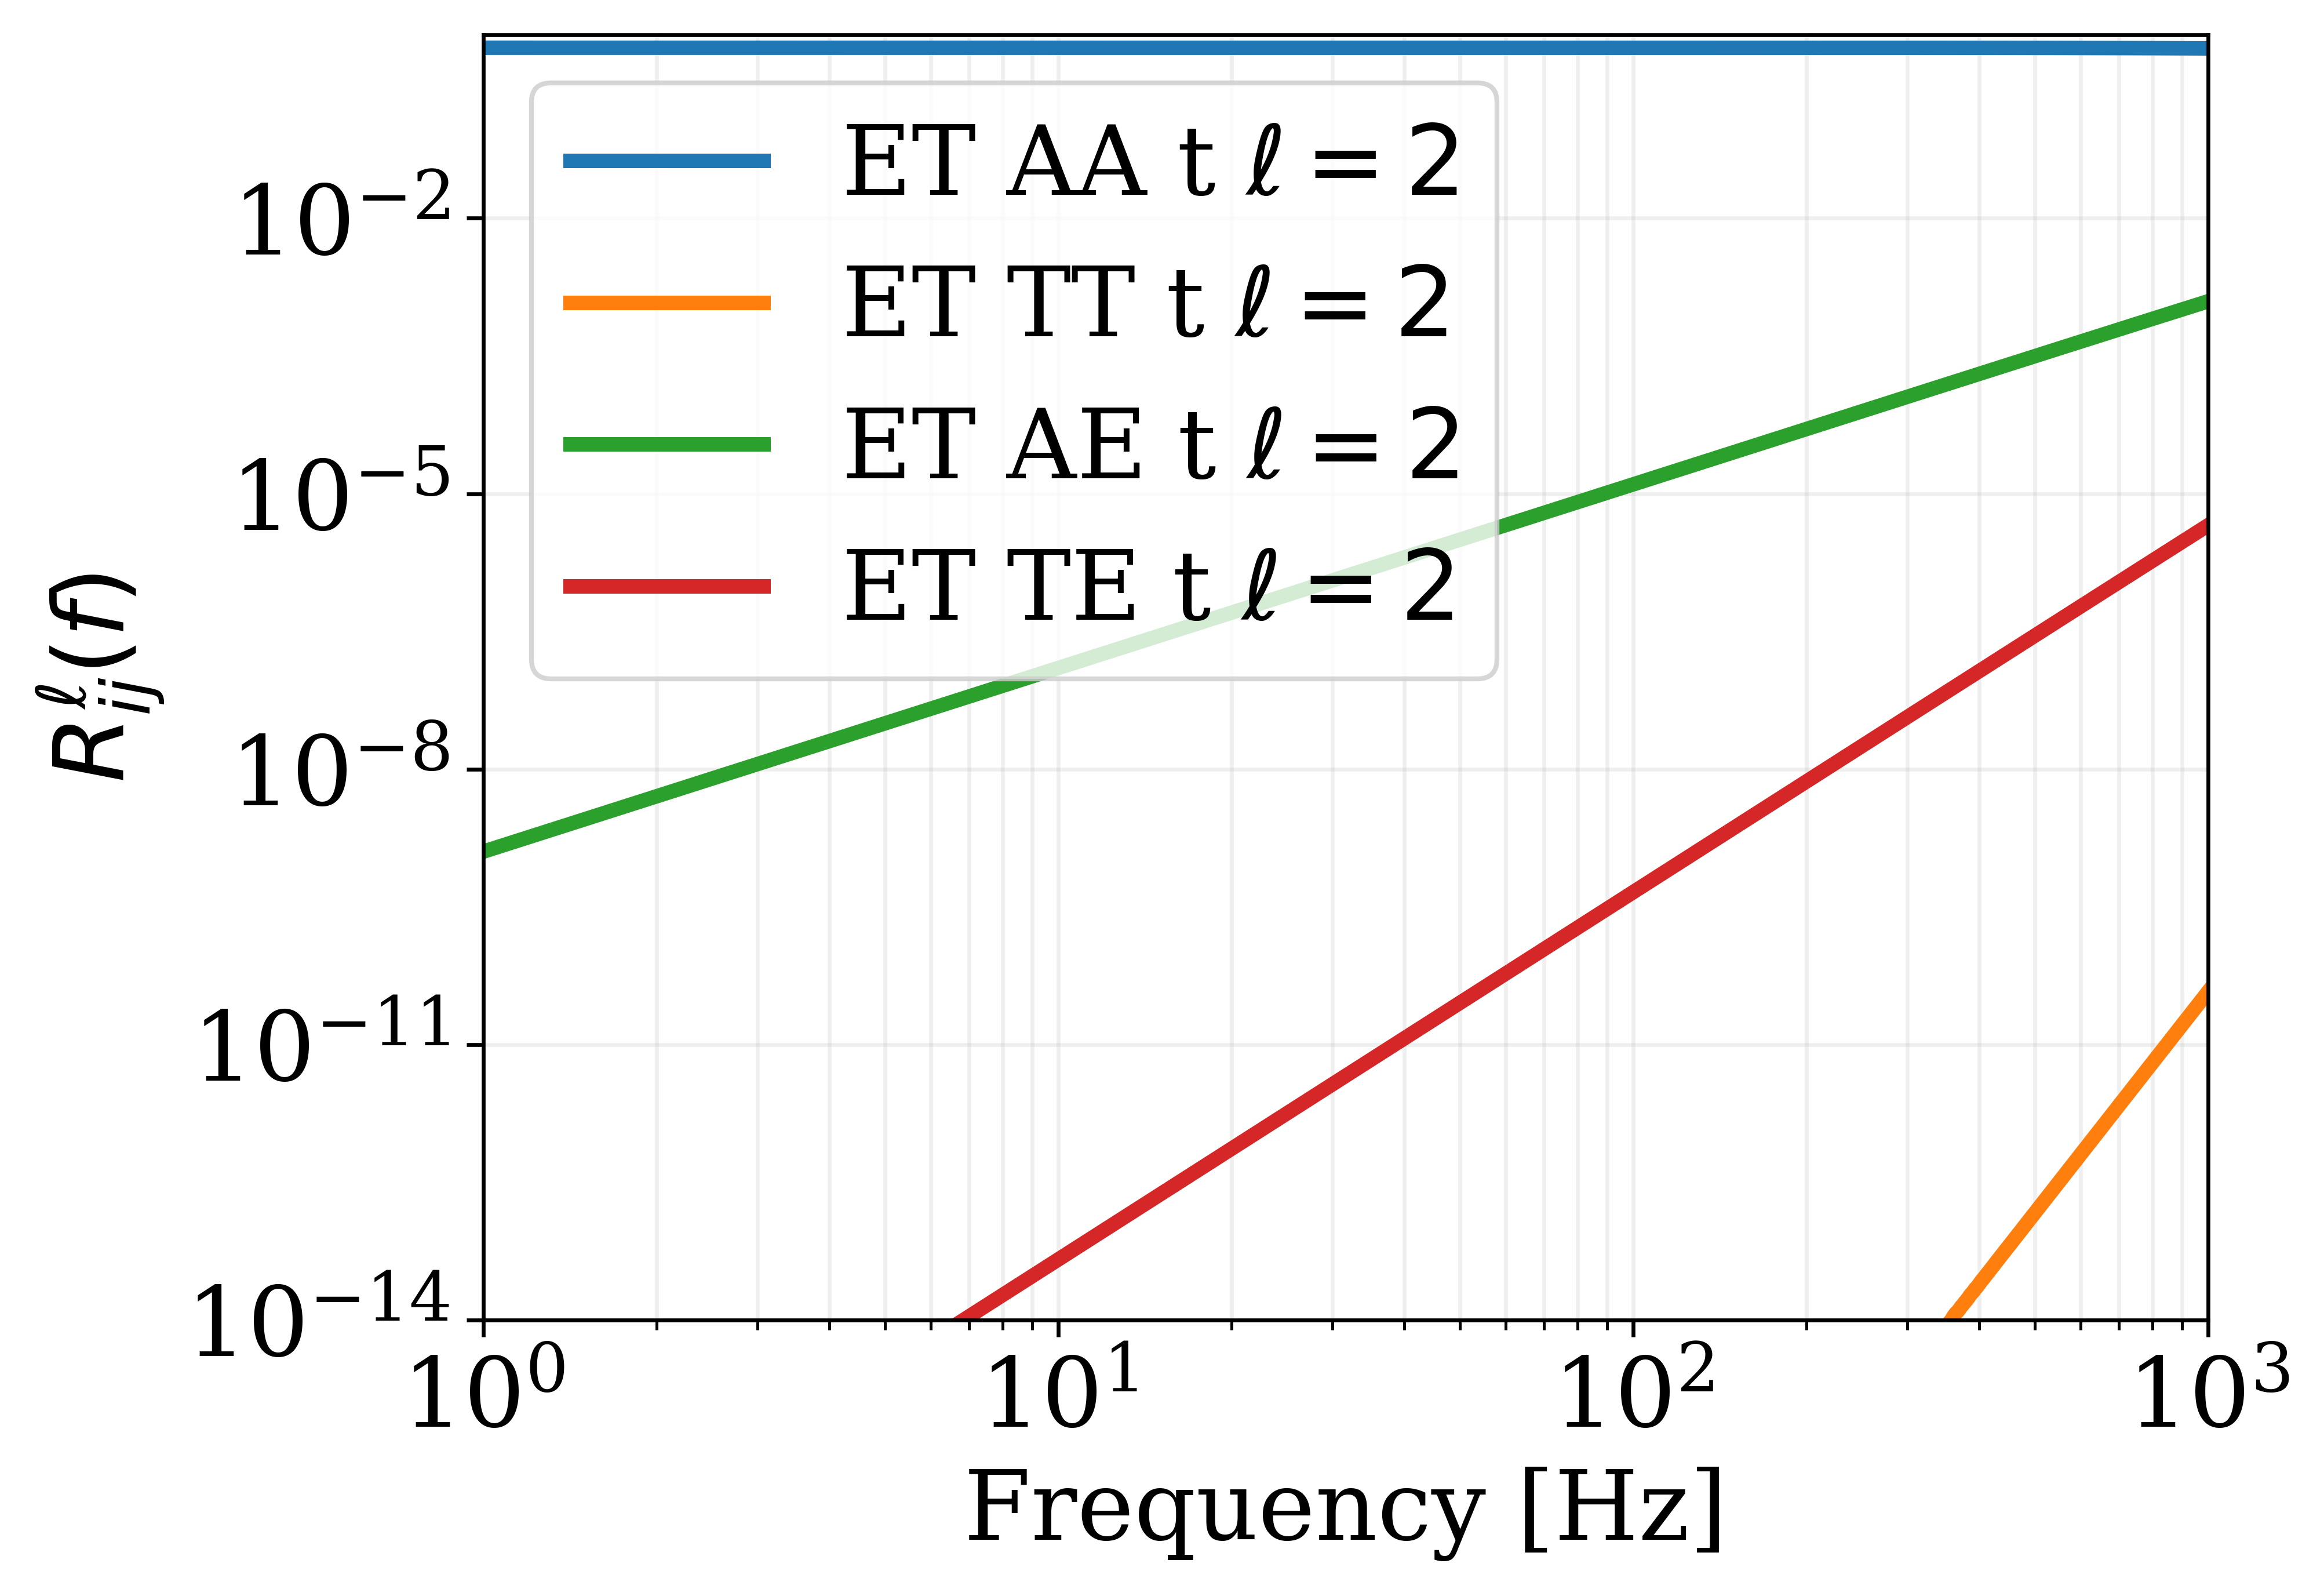

In [183]:
ell = 2
R2_ET_AA = AngularResponse.R_ell(ell,'ET A', 'ET A', f, 't', 0)
R2_ET_TT = AngularResponse.R_ell(ell,'ET T', 'ET T', f, 't', 0)
R2_ET_AE = AngularResponse.R_ell(ell,'ET A', 'ET E', f, 't', 0)
R2_ET_TE = AngularResponse.R_ell(ell,'ET E', 'ET T', f, 't', 0)

plt.figure()
plt.plot(f, R2_ET_AA, label='ET AA t $\ell=2$')
plt.plot(f, R2_ET_TT, label='ET TT t $\ell=2$')
plt.plot(f, R2_ET_AE, label='ET AE t $\ell=2$')
plt.plot(f, R2_ET_TE, label='ET TE t $\ell=2$')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$R_{ij}^{\ell}(f)$')
plt.xlim(f.min(), f.max())
plt.grid(which='both', alpha=0.2)
plt.ylim(1e-14, 1)
plt.legend()

## LISA AET basis

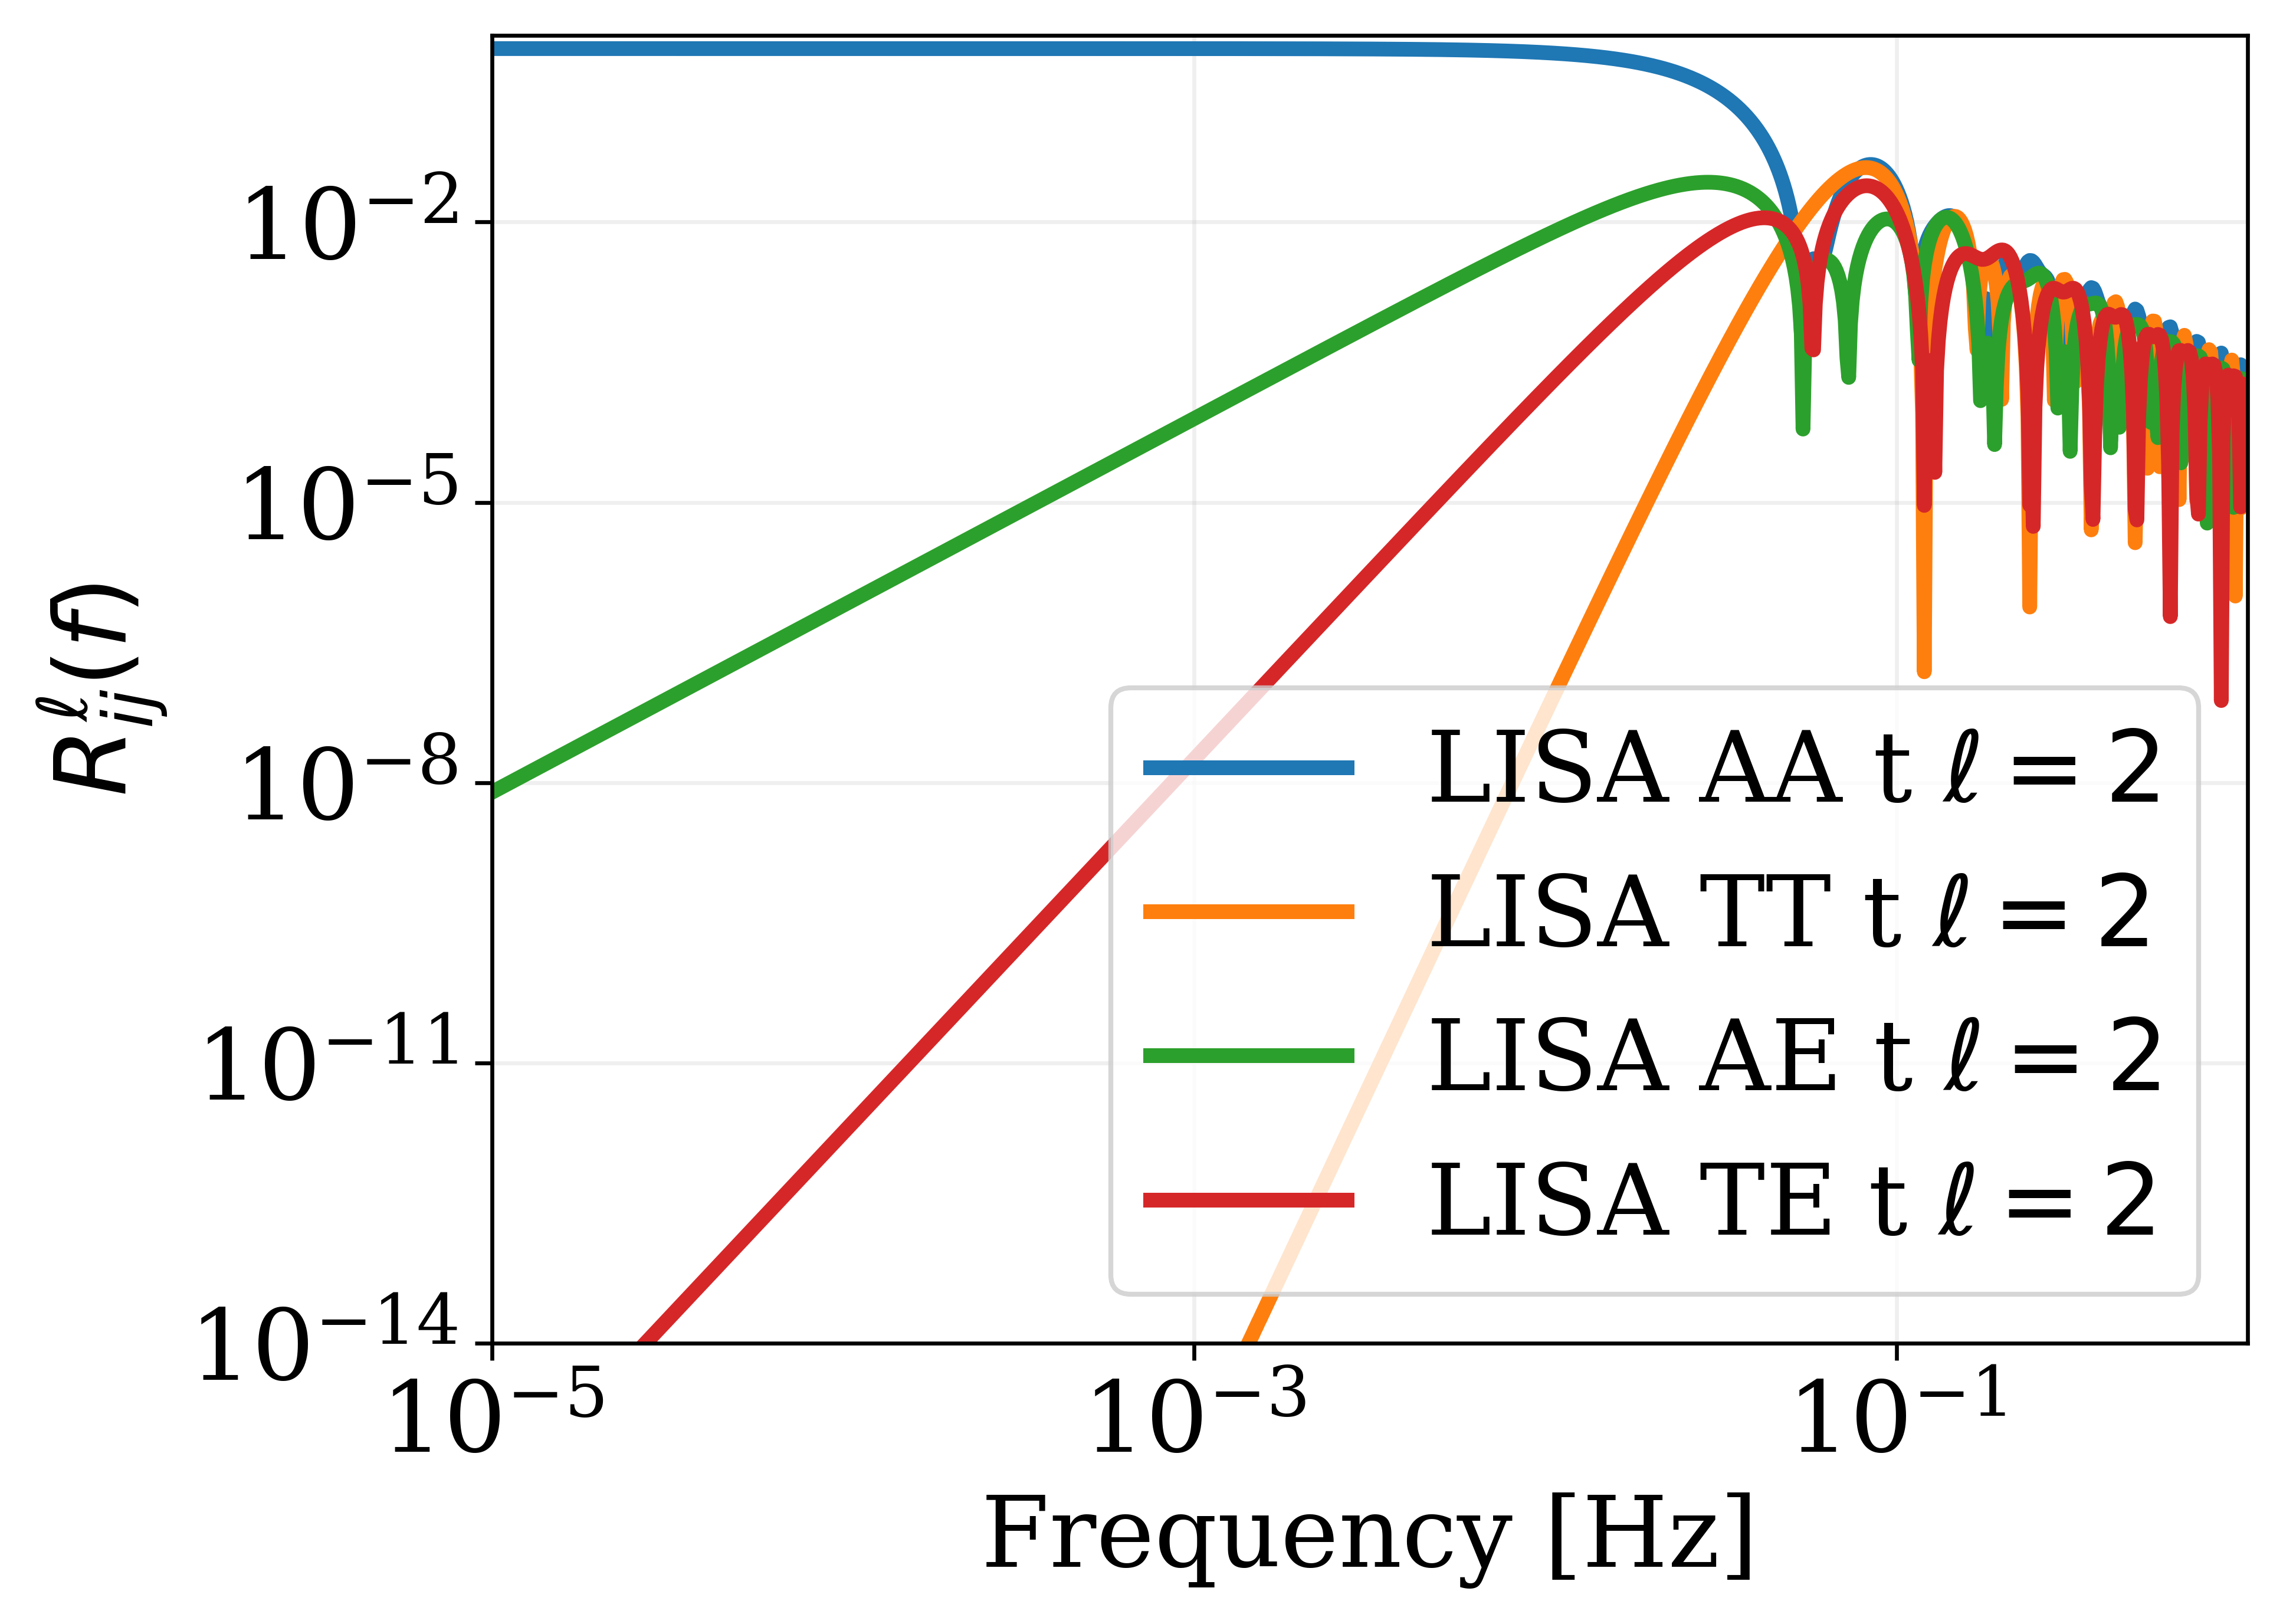

In [184]:
ell = 2
R2_LISA_AA = AngularResponse.R_ell(ell,'LISA A', 'LISA A', f_lisa, 't', 0)
R2_LISA_TT = AngularResponse.R_ell(ell,'LISA T', 'LISA T', f_lisa, 't', 0)
R2_LISA_AE = AngularResponse.R_ell(ell,'LISA A', 'LISA E', f_lisa, 't', 0)
R2_LISA_TE = AngularResponse.R_ell(ell,'LISA E', 'LISA T', f_lisa, 't', 0)


plt.figure()
plt.plot(f_lisa, R2_LISA_AA, label='LISA AA t $\ell=2$')
plt.plot(f_lisa, R2_LISA_TT, label='LISA TT t $\ell=2$')
plt.plot(f_lisa, R2_LISA_AE, label='LISA AE t $\ell=2$')
plt.plot(f_lisa, R2_LISA_TE, label='LISA TE t $\ell=2$')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$R_{ij}^{\ell}(f)$')
plt.xlim(f_lisa.min(), f_lisa.max())
plt.grid(which='both', alpha=0.2)
plt.ylim(1e-14, 1)
plt.legend()


# Angular Power Law Sensitivity Curve

## Ground Based Detectors


Evaluate the sensitivity of a couple of detector to a GWB signal for a specific multipole ell.

sens_ell = Sensitivity_ell.PLS_l(det1, det2, Rl, f, fref, snr, Tobs, beta_min, beta_max, Cl, psi, fI=None, PnI=None, fJ=None, PnJ=None)

Parameters:

- det1, det2: str or list of str
    The name of the detector(s) to consider.
    The names must be in the list of detectors available in the response module.
    The list of available detectors can be obtained by calling the function detectors.available_detectors().
    The names of the detectors are case sensitive.
    If you want to provide a custom detector, you can provide the following information in a list:

    H = [c, xA, xB, l, name]

    - c: array_like of length 3 (Position of the detector in the Earth-centered frame in meters)
    - xA: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - xB: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - l: float (Length of the arm in meters)
    - name: str (Name of the detector)

- Rl: array_like (Angular response for the multipole ell)
- f = array_like (Frequency in Hz)
- fref = float (Reference frequency in Hz)
- snr = float (Signal-to-noise ratio threshold)
- Tobs = float (Observation time in years)
- beta_min = float (Minimum tilt to consider)
- beta_max = float (Maximum tilt to consider)
- Cl = float (Cl for the multipole ell)
- psi: float (Polarization angle in radians)

Optional parameters:
- fI = bool or array_like (Frequency in Hz for the detector I)
- PnI = bool or array_like (Power spectral density for the detector I)
- fJ = bool or array_like (Frequency in Hz for the detector J)
- PnJ = bool or array_like (Power spectral density for the detector J)

In [185]:
Cl = 1e-3
l=2
Tobs = 1
fref = 10
snr = 1

sens2_LIGO = Sensitivity_ell.PLS_ell('LIGO H', 'LIGO L', l, f, 't', 0, fref, snr, Tobs, Cl)
sens2_ET = Sensitivity_ell.PLS_ell('ET X', 'ET Y', l, f, 't', 0, fref,  snr, Tobs,  Cl)
sens2_ET2L0 = Sensitivity_ell.PLS_ell('ET L1', 'ET L2', l, f, 't', 0,  fref, snr, Tobs, Cl, 0)
sens2_ET2L45 = Sensitivity_ell.PLS_ell('ET L1', 'ET L2', l, f, 't', 0,  fref, snr, Tobs,  Cl, np.pi/4)


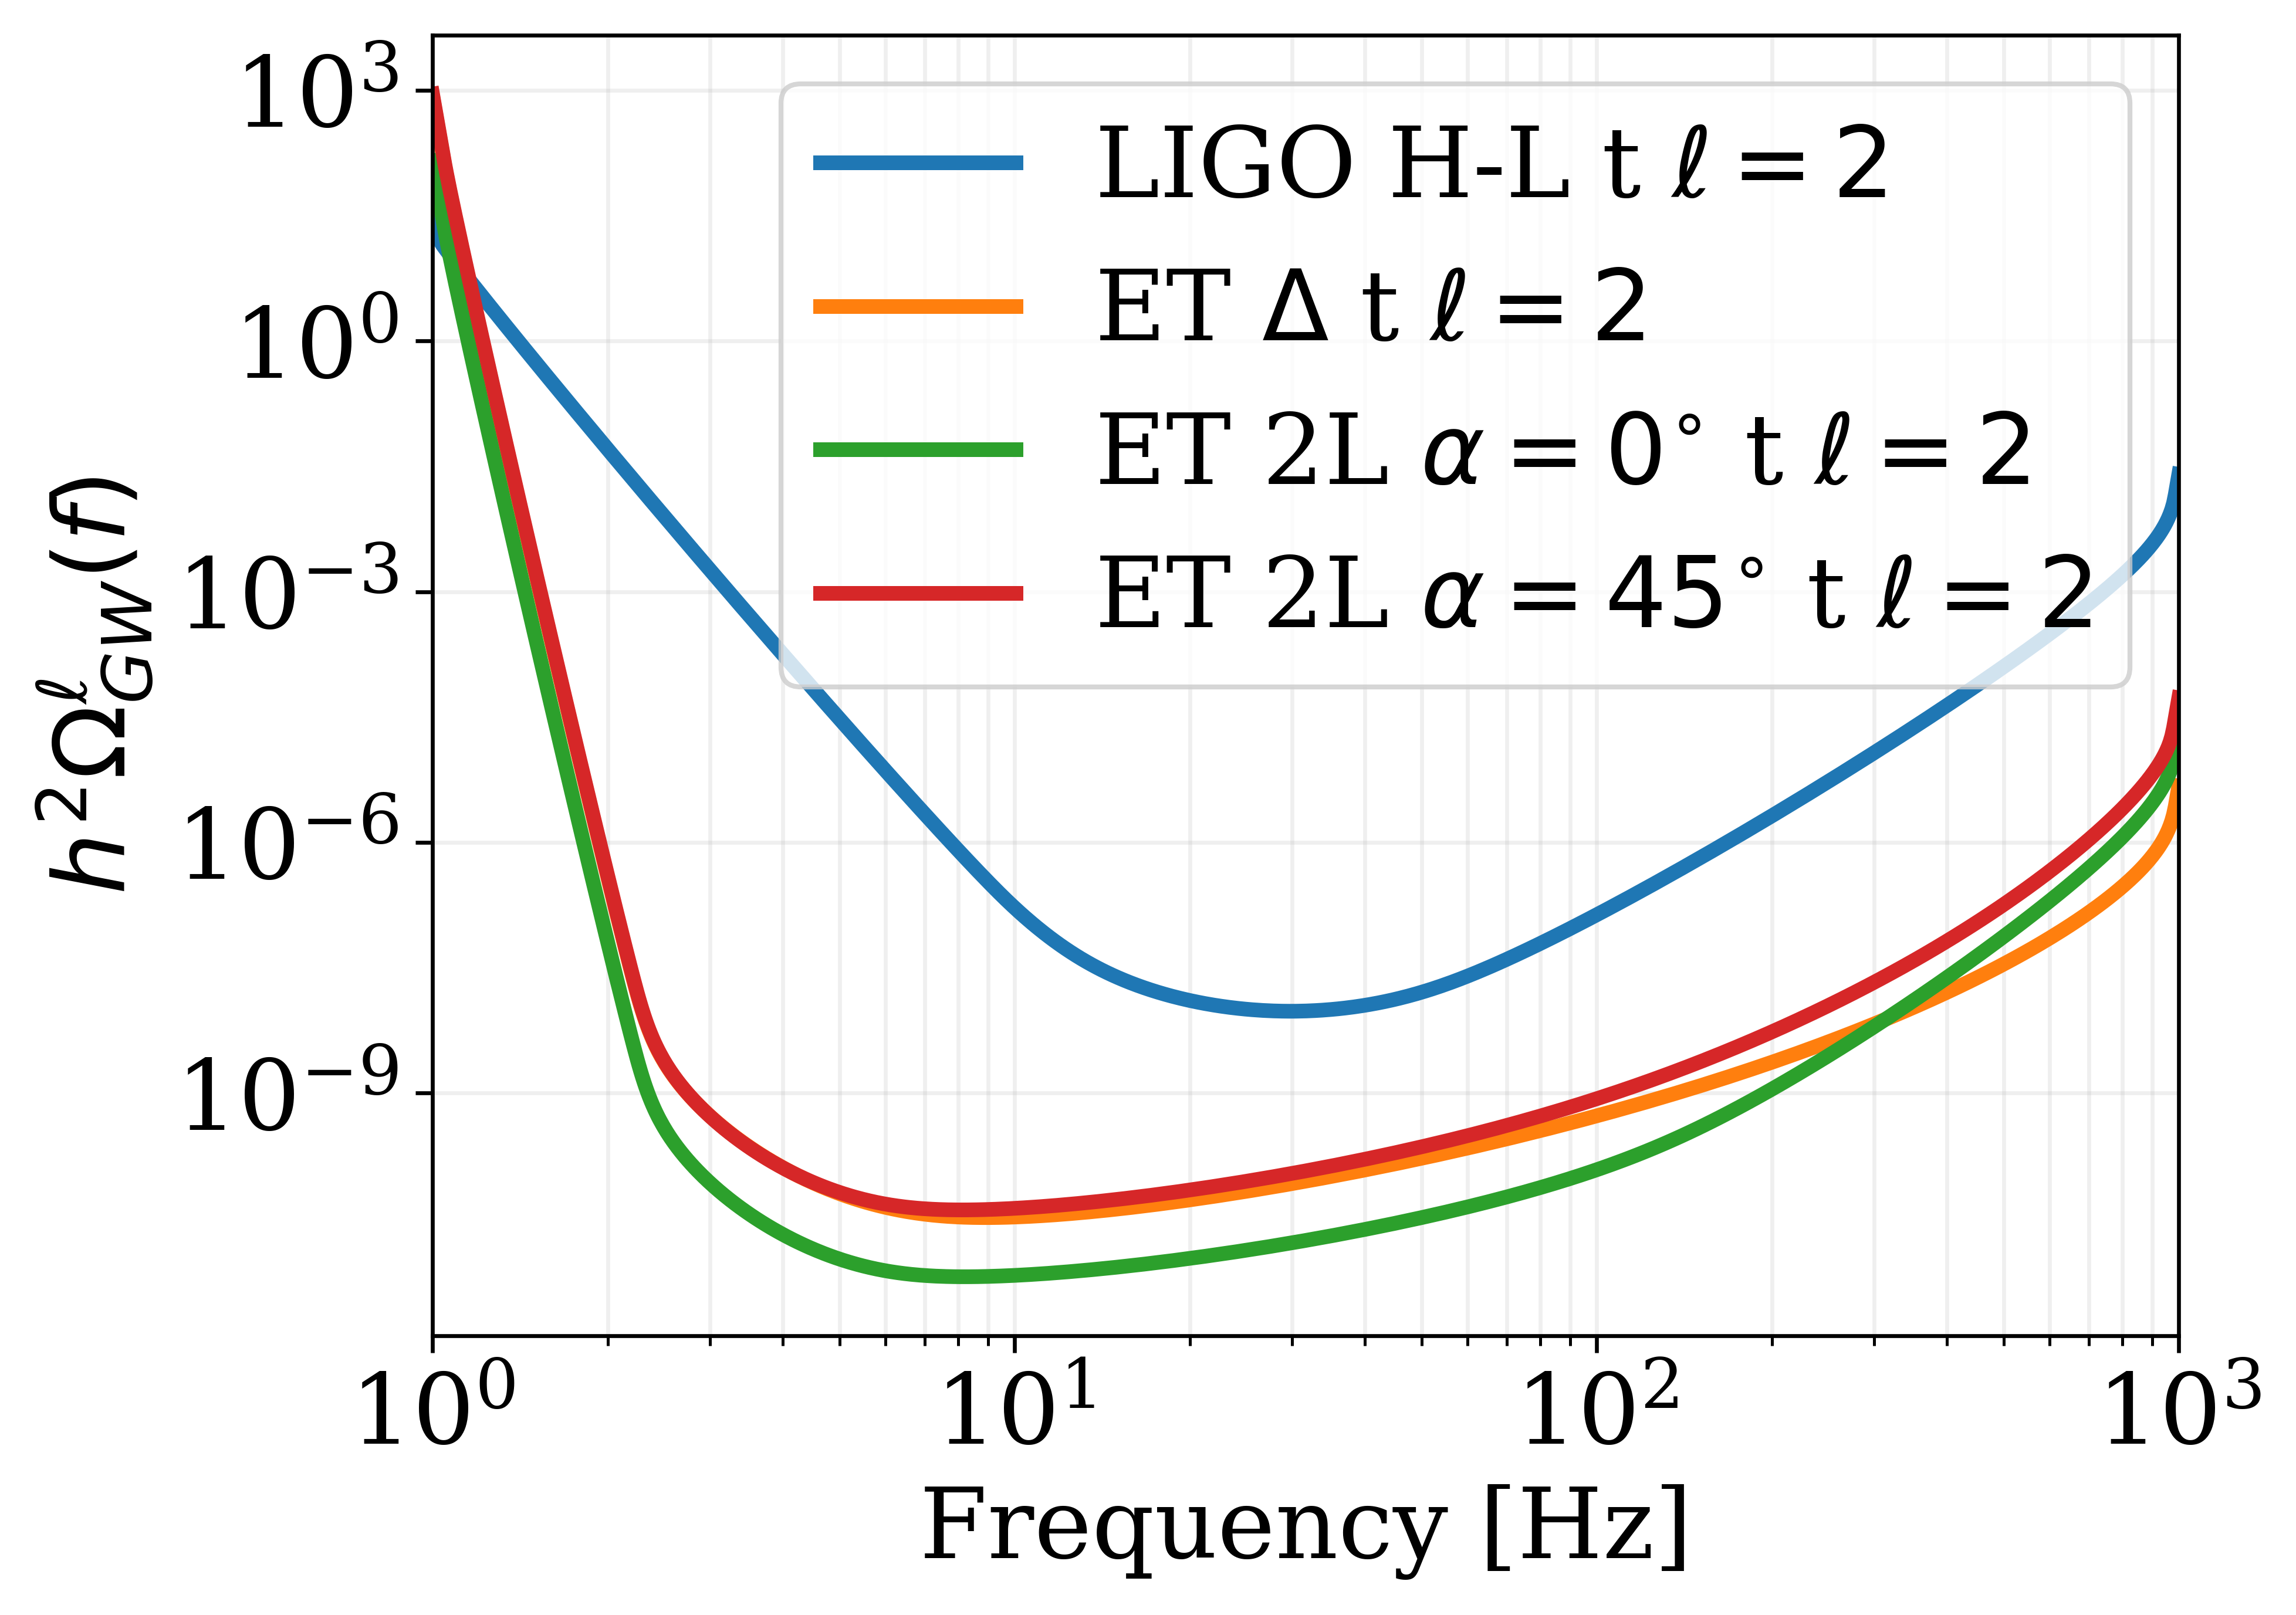

In [186]:
plt.plot(f, sens2_LIGO, label=r'LIGO H-L t $\ell=2$')
plt.plot(f, sens2_ET, label=r'ET $\Delta$ t $\ell=2$')
plt.plot(f, sens2_ET2L0, label=r'ET 2L $\alpha=0^{\circ}$ t $\ell=2$')
plt.plot(f, sens2_ET2L45, label=r'ET 2L $\alpha=45^{\circ}$ t $\ell=2$')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$h^2 \Omega_{GW}^{\ell}(f)$')
plt.xlim(f.min(), f.max())
plt.grid(which='both', alpha=0.2)
plt.legend()


In [189]:
print(sens2_LIGO.min())
print(sens2_ET.min())
print(sens2_ET2L0.min())
print(sens2_ET2L45.min())

print(np.sqrt(4*np.pi))


9.550879775402054e-09
3.239150940419808e-11
6.346289424549924e-12
4.001691051982941e-11
3.5449077018110318


In [187]:
Cl = 1e-3
l=0
Tobs = 1
fref = 10
snr = 1

ET_2_network = Sensitivity_ell.PLS_ell('ET', 'Network', l, f, 't', 0, fref, snr, Tobs, Cl)

print(ET_2_network.min())
print(ET_2_network.min()*np.sqrt(3))

4.8751037299441945e-12
8.443927352431888e-12


In [188]:
print(4.8751037299441945e-12/6.5406380025108e-13)
print(8.443927352431888e-12/1.5416431616206063e-13)

7.453559924999296
54.77225575051662


## LISA

Evaluate the sensitivity of LISA network to a GWB signal for a specific multipole ell.

sens_ell = Sensitivity_ell.PLS_l_LISA(f, l, pol, fref, snr, Tobs, beta_min, beta_max, Cl, psi)
Parameters:
- f = array_like (Frequency in Hz)
- Rl: array_like (Angular response for the multipole ell)
- fref = float (Reference frequency in Hz)
- snr = float (Signal-to-noise ratio threshold)
- Tobs = float (Observation time in years)
- beta_min = float (Minimum tilt to consider)
- beta_max = float (Maximum tilt to consider)
- Cl = float (Cl for the multipole ell)
- psi = float (Polarization angle in radians)


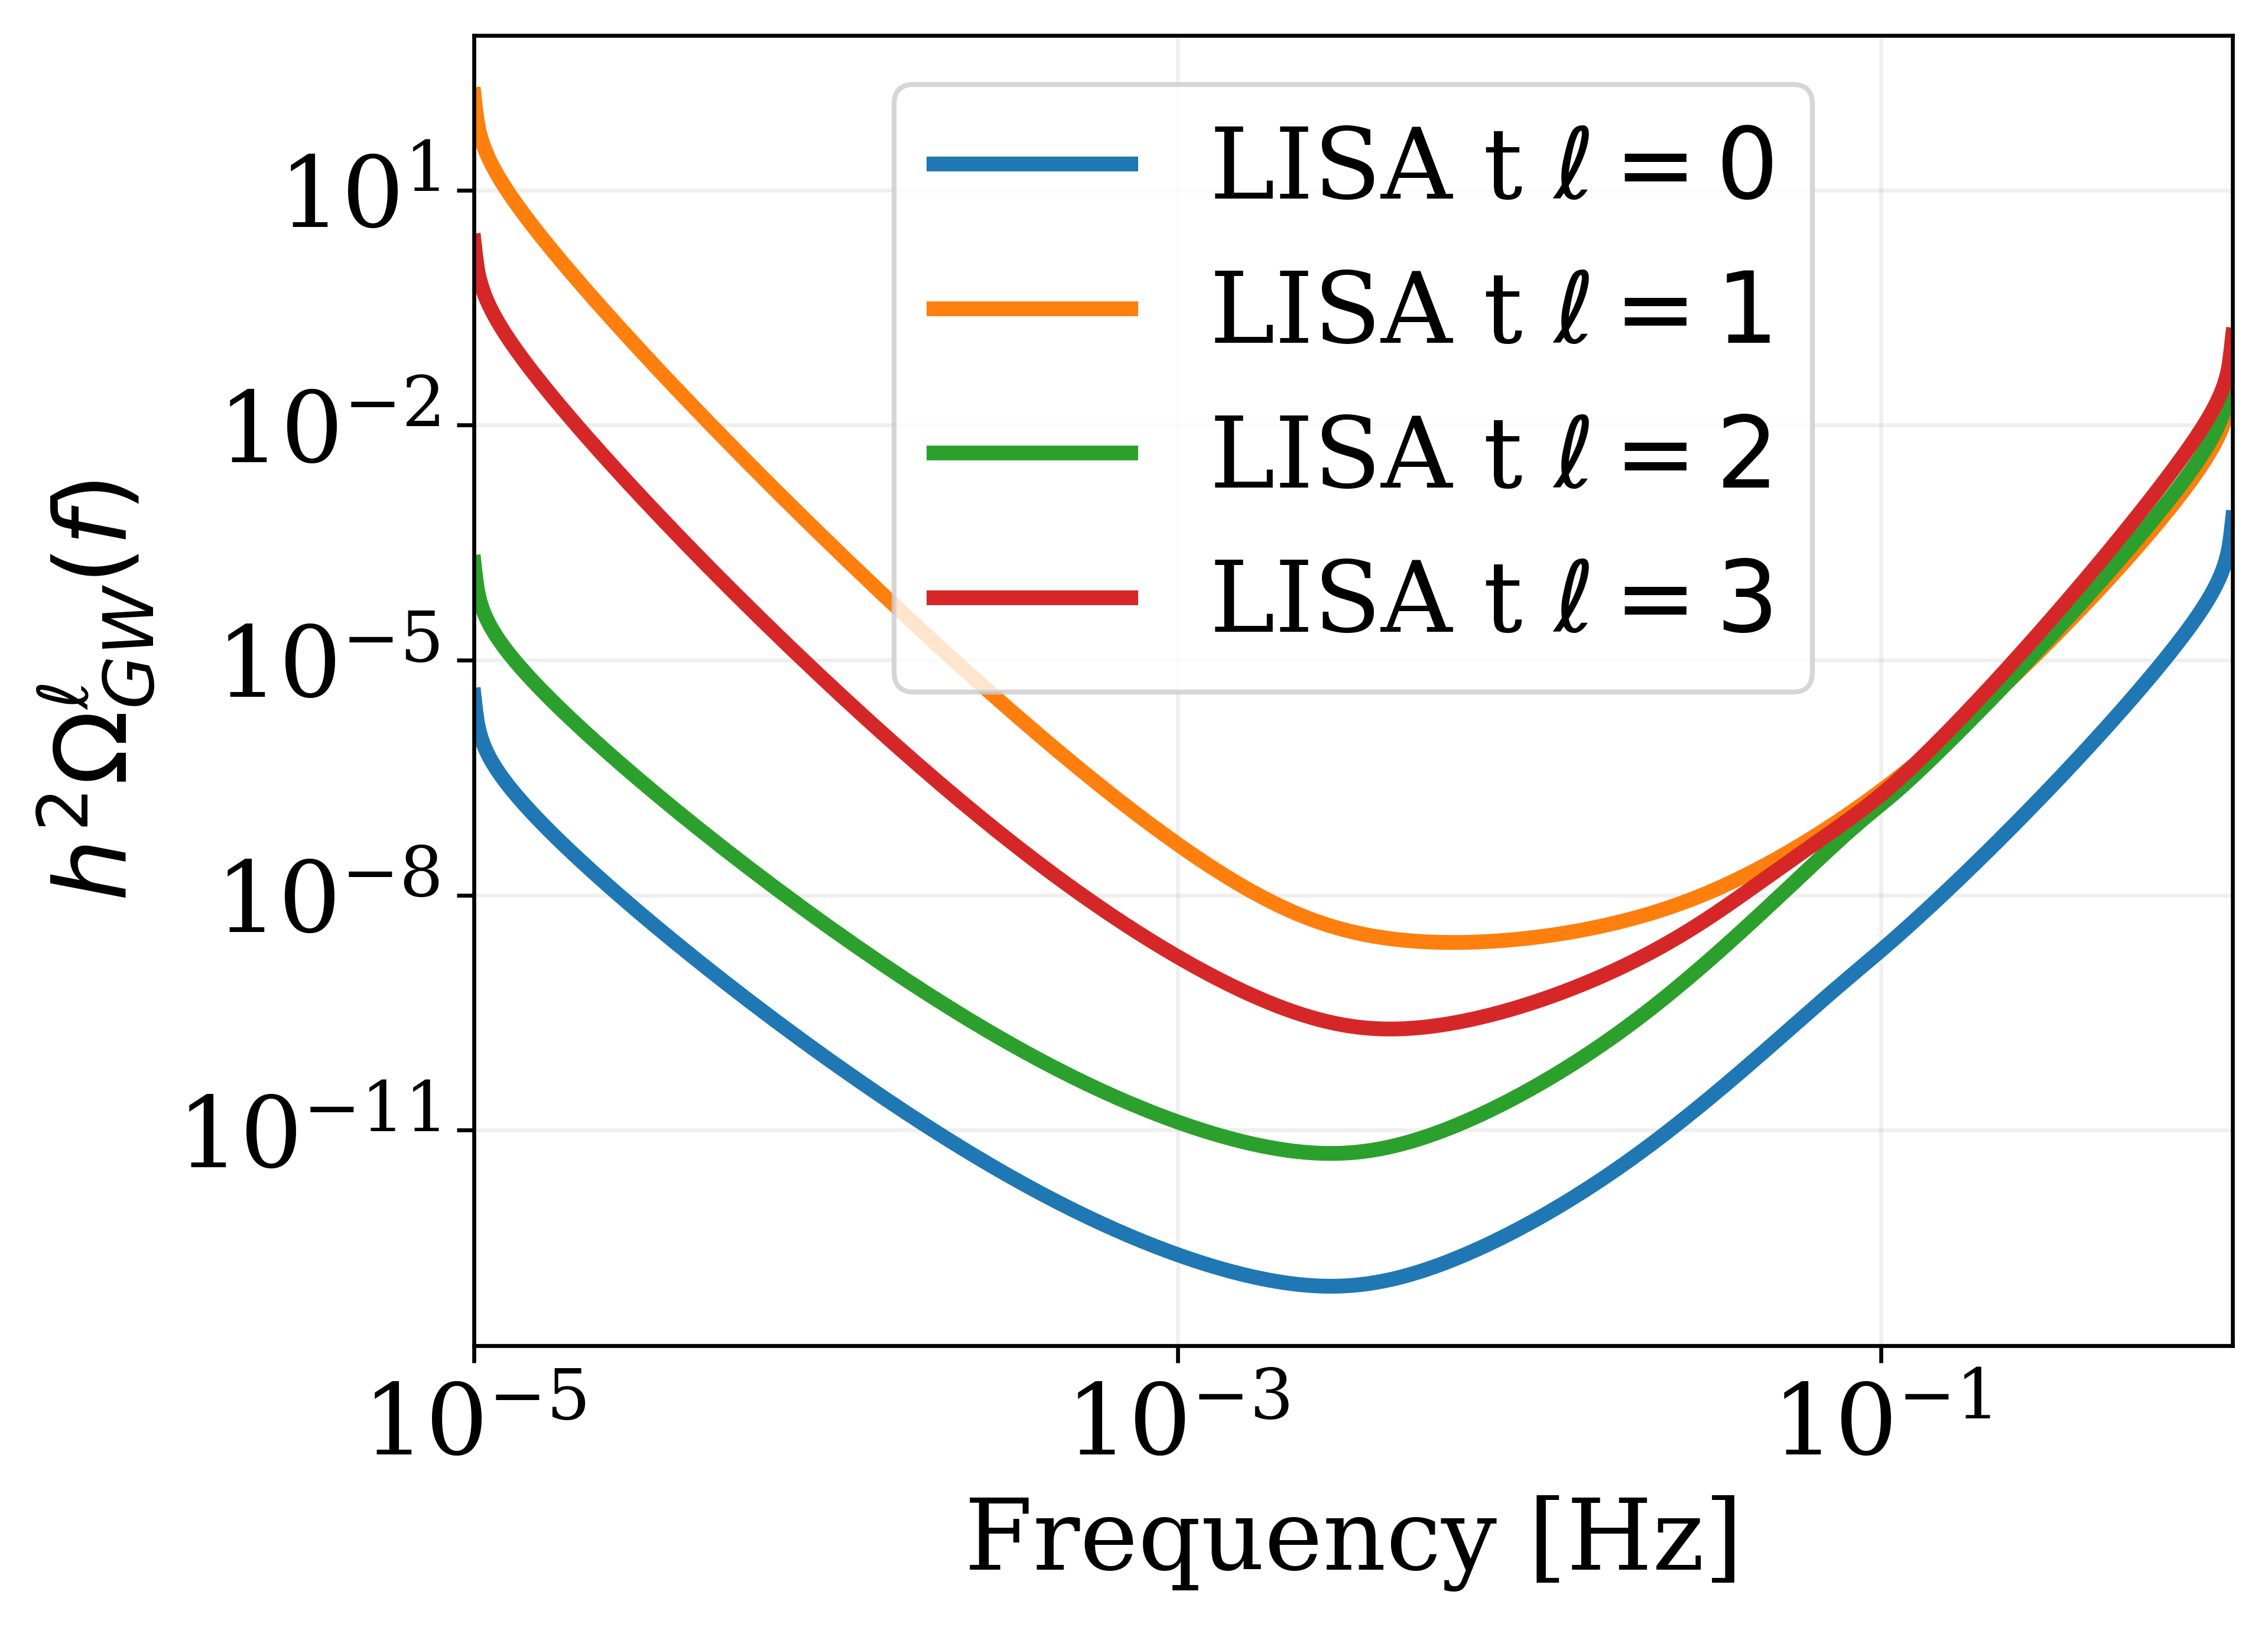

In [155]:
Tobs = 3
snr = 10
sens0_LISA = Sensitivity_ell.PLS_ell('LISA', 'Network', 0, f_lisa, 't', 0, 1e-2, snr, Tobs, 1)
sens1_LISA = Sensitivity_ell.PLS_ell('LISA', 'Network', 1, f_lisa, 't', 0, 1e-2, snr, Tobs, 1e-3)
sens2_LISA = Sensitivity_ell.PLS_ell('LISA', 'Network', 2, f_lisa, 't', 0, 1e-2, snr, Tobs, 1e-3)
sens3_LISA = Sensitivity_ell.PLS_ell('LISA', 'Network', 3, f_lisa, 't', 0, 1e-2, snr, Tobs, 1e-3)

plt.figure()
plt.plot(f_lisa, sens0_LISA, label='LISA t $\ell=0$')
plt.plot(f_lisa, sens1_LISA, label='LISA t $\ell=1$')
plt.plot(f_lisa, sens2_LISA, label='LISA t $\ell=2$')
plt.plot(f_lisa, sens3_LISA, label='LISA t $\ell=3$')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$h^2 \Omega_{GW}^{\ell}(f)$')
plt.xlim(f_lisa.min(), f_lisa.max())
plt.grid(which='both', alpha=0.2)
plt.legend()



In [156]:
print(sens0_LISA.min())
print(sens1_LISA.min())
print(sens2_LISA.min())
print(sens3_LISA.min())

1.019226599636478e-13
2.4891032849172874e-09
5.051655195350282e-12
1.9573875446314613e-10
